# Prédiction des rendements du Dow Jones à partir des rendements des autres indices internationaux

**Projet de Machine Learning ISUP M2 Actuariat 08/01/2021**

* **Ramzi Faroui**
* **Aurélien Rousseau**
* **Corentin Boyeau**

## Sommaire

* [Objectifs du projet](#1)


* [Préparation et visualisation des données](#2)
    * [Importation des packages](#21)
    * [Importation et description des données](#22)
    * [Création de variables ](#23)
        * [Rendements journaliers](#231)
        * [Variable catégoriel](#232)
    * [Séparation du dataset](#24)
    * [Visualisation des données](#25)
    
    
* [Prédictions](#3)
    * [Choix des variables](#31)
        * [Description des 3 méthodes de sélections de variables](#311)
        * [Filter method : Pearson Correlation](#312)
        * [Filter method : test ANOVA](#313)
        * [Wrapper method : Recursive Feature Elimination](#314)
            * [RFECV avec modèle linéaire](#3141)
            * [RFECV avec régression logistique Lasso](#3142)
        * [Embedded method : Select From Model](#315)
            * [Select From Model avec régression logistique Lasso](#3151)
            * [Select From model avec Random forests et l'OOB error](#3152)
        * [Choix final](#316)
    * [Classification](#32)
        * [1er modèle : CART](#321)
        * [2ème modèle : Random Forest](#322)
        * [3ème modèle : Régression logistique pénalisation Lasso](#323)
        * [4ème modèle : KNN](#324)
        * [Choix du meilleur modèle de classification](#325)
    * [Regression](#33)
        * [1er modèle : Modèle linéaire](#331)
        * [2ème modèle : SVM](#332)
        * [3ème modèle : Ridge](#333)
        * [Choix du meilleur modèle de régression](#334)
      
      
* [Définition des stratégies d'investissement](#4)
    * [Investissement à partir du meilleur modèle de classification](#41)
    * [Investissement à partir des probabilités de Random Forest - Détermination seuil](#42)
        * [Analyse graphique de l'impact du seuil sur les résultats d'investissements](#421)
        * [Résultats pour le seuil sélectionné](#422)
    * [Investissement à partir du meilleur modèle de régression - Détermination seuil](#43)
        * [Analyse graphique de l'impact du seuil sur les résultats d'investissements](#431)
        * [Résultats pour le seuil sélectionné](#432)
        
        
* [Récapitulatif des résultats et choix de l'investissement optimal](#5)
    * [Fonctions permettant de remplir le tableau récapitulatif](#51)
    * [Tableau récapitulatif](#52)
    
    
* [Résultats sur le test set](#6)
    * [Résultats finaux sur le test set (du 02/01/2019 aux 13/11/2020)](#61)
    * [Résultats en période de crise (du 12/02/2020 au 23/03/2020)](#62)
    
    
* [Prochaines étapes et limites de l'étude](#7)
    * [Learning Curve - Besoin de données supplémentaires ?](#71)
    * [Limites et améliorations possibles](#72)
    
    
* [Conclusion](#8)


# Objectifs du projet <a class="anchor" id="1"></a>

Si on a souvent tendance à penser que la bourse américaine influence les autres bourses, l'objectif de ce projet est inverse. **Peut-on prévoir de manière suffisamment convaincante les rendements du Dow Jones, à partir uniquement de la performance journalière des autres indices boursiers internationaux ?**

Pour comprendre l'idée, rappelons tout d'abord les horaires d'ouverture (heure française) des différentes bourses, ainsi que les indices associées que nous utiliserons :

* Etats-unis - 15h30 à 22h - Dow Jones
* France - 9h à 17h30 - CAC40
* Allemagne - 9h à 20h - DAX30
* Angleterre - 9h30 à 17h30 - FTSE100
* Japon - 1h à 3h et 4h30 à 7h - Nikkei225
* Chine - 2h30 à 4h30 et 6h à 8h - SSE Composite

Pour prédire les rendements du Dow Jones nous utiliserons donc les rendements des bourses européennes uniquement jusqu'à 15h, soit avant l'ouverture de Wall Street (on aurait pu même les prendre jusqu'à 15h30 mais nous ne disposions pas de l'information). Ainsi, tous les jours, à 15h, à partir de la tendance donnée par les bourses qui sont déjà ouvertes (ou qui ont déjà fermées concernant les bourses asiatiques) l'idée est de déterminer si les rendements journaliers du Dow Jones seront positifs ou non.

De plus, nous avons décidé d'apporter une vision "investissement" au projet. L'idée est la suivante : lorsque nos prédictions sont suffisamment convaincantes (par exemple que notre prédiction nous indique des rendements positifs), on décide d'investir (sur un fond indiciel indexé au Dow Jones) au prix d'ouverture à 15h30 et de revendre au prix de fermeture à 22h. L'idée finale sera de comparer cette stratégie avec les rendements apportés par un investissement long-terme.  

C'est pourquoi on s'attardera principalement sur de la classification, l'idée étant de prédire "1" lorsque l'on veut investir et "0" dans le cas contraire. Dans un premier temps, cette classification sera simplement de prédire la positivité ou non des rendements, mais on accordera une autre partie, à l'étude du seuil de classification et son impact sur les rendements associés. Par exemple, plutôt que d'investir lorsque le modèle Random Forest prédit une positivité des rendements avec une probabilité supérieur à 50%, monter le seuil à 60%, 70% etc ... pour voir l'impact sur les résultats d'investissement.

Enfin, dans la dernière partie, on s'attardera aux améliorations possibles de notre étude, ainsi qu'aux éventuelles limites que pose la stratégie d'investissement décrite ci-dessus.

In [2]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import datetime
import graphviz # conda install python-graphviz

# Préparation et visualisation des données  <a class="anchor" id="2"></a>

## Importation des packages <a class="anchor" id="21"></a>

## Importation et description des données <a class="anchor" id="22"></a>

La base de données se compose de différentes variables pour les 6 indices boursiers précédemment cités, soit le Dow Jones (Etats-Unis), le CAC40 (France), le DAX30 (Allemagne), le FTSE100 (Angleterre), le Nikkei 225 (Japon) et le SSE_Composite (Chine). Pour rappel, le Dow Jones est un indice boursier américain créé en 1896 par Charles Dow et Edward Jones. Il représente 30 des plus importantes entreprises américaines et il est pondéré sur la valeur des actions des entreprises qui le compose.

Pour l'ensemble de ces 6 indices nous disposons des 2 variables suivantes :

* Open_Index : valeur de l'indice à l'ouverture du marché pour une date donnée
* Close_Index : valeur de l'indice à la fermeture du marché pour une date donnée

*Ces informations ont été récupérées sur le site [Yahoo Finance](https://finance.yahoo.com/quote/%5EDJI/history/)*

De plus pour les 3 indices européens, nous disposons en plus de la variable suivante : 

* 15h_Index : valeur de l'indice à 15h pour une date donnée

*Ces informations ont été récupérées sur le site [dukascopy](https://www.dukascopy.com/trading-tools/widgets/quotes/historical_data_feed?fbclid=IwAR2f9gvYztXCpAuCkDMCewedqo0_ozmF9Hy5M9Z4pd5dG1jXHSzNW-TioUo). A noter que les valeurs horaires des indices est normalement payantes, c'est un des rares sites à fournir l'information gratuitement.*

Les variables Open et Close vont du 3 décembre 2012 au 13 novembre 2020. Les données à 15h ne sont renseignées qu'à partir de janvier 2013.

In [3]:
data_all = pd.read_csv("Stock_Index_World_2013_2020.csv", sep=";")

data_all['Date'] = pd.to_datetime(data_all['Date'], format = '%d/%m/%Y')  #Conversion en format date

data_all.head()

,Date,Open_DJ,Close_DJ,Open_SSE_Composite,Close_SSE_Composite,Open_N225,Close_N225,Open_CAC40,15h_CAC40,Close_CAC40,Open_DAX,15h_DAX,Close_DAX,Open_FTSE100,15h_FTSE100,Close_FTSE100
0,2012-12-03,13027.730469,12965.599609,1977.254028,1959.766968,9484.200195,9458.179688,3567.899902,NaN,3566.590088,7427.410156,NaN,7435.209961,5866.799805,NaN,5871.200195
1,2012-12-04,12966.450195,12951.780273,1956.615967,1975.142944,9419.150391,9432.459961,3563.030029,NaN,3580.479980,7428.129883,NaN,7435.120117,5871.200195,NaN,5869.000000
2,2012-12-05,12948.959961,13034.490234,1973.107056,2031.906982,9380.370117,9468.839844,3602.209961,NaN,3590.500000,7480.589844,NaN,7454.549805,5869.000000,NaN,5892.100098
3,2012-12-06,13026.190430,13074.040039,2029.562012,2029.237061,9535.690430,9545.160156,3598.129883,NaN,3601.649902,7469.540039,NaN,7534.540039,5892.100098,NaN,5901.399902
4,2012-12-07,13072.870117,13155.129883,2028.765991,2061.785889,9547.139648,9527.389648,3606.760010,NaN,3605.610107,7539.779785,NaN,7517.799805,5901.399902,NaN,5914.399902


In [34]:
data_all.iloc[:,0]

0      2012-12-03
1      2012-12-04
2      2012-12-05
3      2012-12-06
4      2012-12-07
          ...    
1998   2020-11-09
1999   2020-11-10
2000   2020-11-11
2001   2020-11-12
2002   2020-11-13
Name: Date, Length: 2003, dtype: datetime64[ns]

In [31]:
data_all.loc[1:5]

,Date,Open_DJ,Close_DJ,Open_SSE_Composite,Close_SSE_Composite,Open_N225,Close_N225,Open_CAC40,15h_CAC40,Close_CAC40,Open_DAX,15h_DAX,Close_DAX,Open_FTSE100,15h_FTSE100,Close_FTSE100
1,2012-12-04,12966.450195,12951.780273,1956.615967,1975.142944,9419.150391,9432.459961,3563.030029,NaN,3580.479980,7428.129883,NaN,7435.120117,5871.200195,NaN,5869.000000
2,2012-12-05,12948.959961,13034.490234,1973.107056,2031.906982,9380.370117,9468.839844,3602.209961,NaN,3590.500000,7480.589844,NaN,7454.549805,5869.000000,NaN,5892.100098
3,2012-12-06,13026.190430,13074.040039,2029.562012,2029.237061,9535.690430,9545.160156,3598.129883,NaN,3601.649902,7469.540039,NaN,7534.540039,5892.100098,NaN,5901.399902
4,2012-12-07,13072.870117,13155.129883,2028.765991,2061.785889,9547.139648,9527.389648,3606.760010,NaN,3605.610107,7539.779785,NaN,7517.799805,5901.399902,NaN,5914.399902
5,2012-12-10,13154.889648,13169.879883,2067.323975,2083.770020,9584.459961,9533.750000,3587.320068,NaN,3612.100098,7484.950195,NaN,7530.919922,5914.399902,NaN,5921.600098


Prise en compte des valeurs manquantes :

* Lors de l'agrégation on a du faire face à des valeurs manquantes étant donné que les jours travaillés ne sont pas forcément les mêmes en fonction des pays. Dans ce cas si on ne dispose pas de l'indice X pour la ligne n de notre dataset, on a considéré la valeur de la ligne n-1. A noter qu'il n'y a aucune valeur manquante pour le Dow Jones car nous avons pris les jours travaillés américain comme base, la valeur des indices lorsque Wall Street est fermé est donc ignorée.

Pour les variables concernant le CAC40, le DAX30 et le FTSE100 le mois de décembre 2012 n'est pas renseigné, on décide donc d'ignorer ce mois et de commencer l'étude à partir du mois de janvier 2013

In [4]:
data = data_all[20:].reset_index(drop=True)  #On retire le mois de décembre 2012

## Création de variables <a class="anchor" id="23"></a>

### Rendements journaliers <a class="anchor" id="231"></a>

In [5]:
Index = ["DJ","SSE_Composite", "N225"]


for i in range (len(Index)):   #Création des rendements pour les variables dont on veut l'ensemble de la journée
    Open= "Open_"+Index[i]
    Close="Close_"+Index[i]
    Nom_var = "Returns_" + Index[i]
    data[Nom_var]=((data[Close]-data[Open])/data[Open])
    
Index_15h = ["CAC40", "DAX", "FTSE100"]

for i in range (len(Index_15h)):  #Création des rendements uniquement de 9h à 15h 
    Open= "Open_"+Index_15h[i]
    Close="15h_"+Index_15h[i]
    Nom_var = "Returns_9_15_" + Index_15h[i]
    data[Nom_var]=((data[Close]-data[Open])/data[Open])
    

Var = ["Returns_"+Index[i] for i in range(len(Index))]
Var+= ["Returns_9_15_"+Index_15h[i] for i in range(len(Index_15h))]
    

Calcul des rendements pour le Dow Jones, N225 et SSE_Composite :

$Returns\_index = \frac{Close\_index - Open\_index}{Open\_index}$

Calcul des rendements pour le CAC40, FTSE100, DAX30 :

$Returns\_9\_15\_index = \frac{15h\_index - Open\_index}{Open\_index}$

### Variable catégoriel <a class="anchor" id="232"></a>

In [6]:
data['Returns_DJ_positive']=(data['Returns_DJ']>0).astype(int)
data['Returns_N225_positive']=(data['Returns_N225']>0).astype(int)
data['Returns_SSE_Composite_positive']=(data['Returns_SSE_Composite']>0).astype(int)
data['Returns_9_15_FTSE100_positive']=(data['Returns_9_15_FTSE100']>0).astype(int)
data['Returns_9_15_DAX_positive']=(data['Returns_9_15_DAX']>0).astype(int)
data['Returns_9_15_CAC40_positive']=(data['Returns_9_15_CAC40']>0).astype(int)

data.head()

,Date,Open_DJ,Close_DJ,Open_SSE_Composite,Close_SSE_Composite,Open_N225,Close_N225,Open_CAC40,15h_CAC40,Close_CAC40,...,Returns_N225,Returns_9_15_CAC40,Returns_9_15_DAX,Returns_9_15_FTSE100,Returns_DJ_positive,Returns_N225_positive,Returns_SSE_Composite_positive,Returns_9_15_FTSE100_positive,Returns_9_15_DAX_positive,Returns_9_15_CAC40_positive
0,2013-01-02,13104.299805,13412.549805,2236.460938,2269.127930,10406.360352,10395.179688,3702.659912,3718.29,3733.929932,...,-0.001074,0.004221,0.010547,0.023206,1,0,1,1,1,1
1,2013-01-03,13413.009766,13391.360352,2236.460938,2269.127930,10406.360352,10395.179688,3724.300049,3717.11,3721.169922,...,-0.001074,-0.001931,-0.000247,0.000463,0,0,1,1,0,0
2,2013-01-04,13391.049805,13435.209961,2289.510010,2276.991943,10604.500000,10688.110352,3713.320068,3716.21,3730.020020,...,0.007884,0.000778,0.002327,0.004360,1,1,0,1,1,1
3,2013-01-07,13436.129883,13384.290039,2271.663086,2285.364014,10743.690430,10599.009766,3731.489990,3703.59,3704.639893,...,-0.013467,-0.007477,-0.003282,-0.003752,0,0,1,0,0,0
4,2013-01-08,13377.419922,13328.849609,2284.654053,2276.070068,10544.209961,10508.059570,3694.209961,3716.88,3705.879883,...,-0.003428,0.006137,0.001748,0.000465,0,0,0,1,1,1


Création de variables catégoriel qui sont égales à 1 lorsque les rendements sont positifs et 0 lorsque les rendements sont négatifs. La variable du Dow Jones sera utilisée pour la classification. Pour les autres indices elles seront utiles uniquement pour la création de graphes dans la partie suivante.

## Séparation du dataset <a class="anchor" id="24"></a>

Pour la séparation du dataset en train/test nous avons  décidé ne pas le faire de manière aléatoire 
comme on pourrait le faire avec sklearn mais de faire l'entraînement des années 2013 à 2018 et de tester les modèles
sur les années 2019 et 2020.  

Cela permettra de mettre en place des stratégies d'investissement comme si nous avions mis en place les modèles fin 2018.

In [7]:
data_train = data.iloc[0:1510]
data_test = data.iloc[1510:].reset_index(drop=True)

#Variables explicatives X et target y
VarExpli = Var[1:]  #Nom des variables explicatives (on enlève juste Returns_DJ qu'on veut prédire)

X_train = data_train[VarExpli]
y_trainReg = data_train["Returns_DJ"]
y_trainClassif = data_train["Returns_DJ_positive"]

X_test = data_test[VarExpli]
y_testReg = data_test["Returns_DJ"]
y_testClassif = data_test["Returns_DJ_positive"]


In [8]:
X_train.head()

,Returns_SSE_Composite,Returns_N225,Returns_9_15_CAC40,Returns_9_15_DAX,Returns_9_15_FTSE100
0,0.014607,-0.001074,0.004221,0.010547,0.023206
1,0.014607,-0.001074,-0.001931,-0.000247,0.000463
2,-0.005468,0.007884,0.000778,0.002327,0.004360
3,0.006031,-0.013467,-0.007477,-0.003282,-0.003752
4,-0.003757,-0.003428,0.006137,0.001748,0.000465


## Visualisation des données <a class="anchor" id="25"></a>

Text(0.5, 1.0, 'Evolution des valeurs normalisées de fermeture du Dow-Jones, du N225 et du FTSE100')

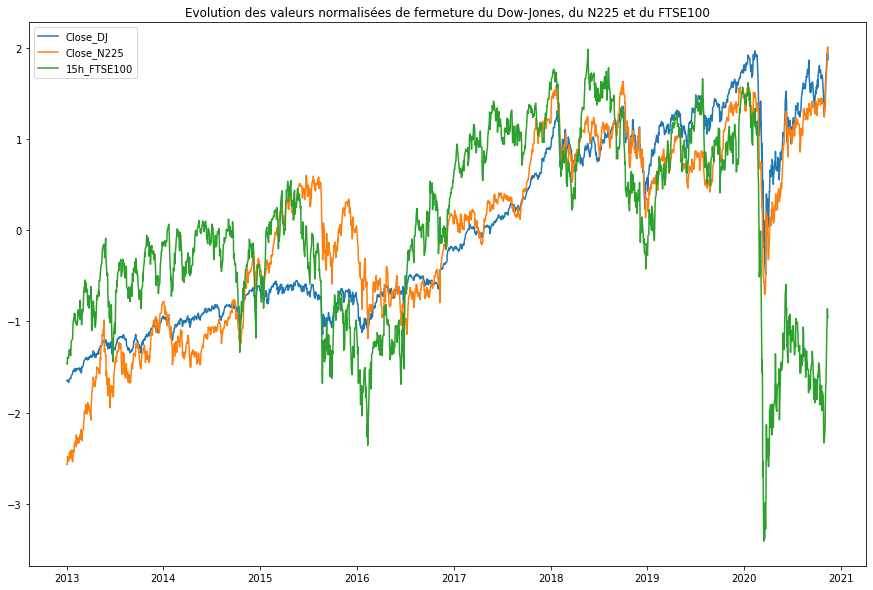

In [9]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

Close = ['Close_DJ','Close_N225',"15h_FTSE100"]

Standardized_close = pd.DataFrame(data[Close])
scaler.fit(Standardized_close)
Standardized_close = scaler.transform(Standardized_close)


plt.figure(figsize=(15, 10)) 
for i in range(len(Close)):
    plt.plot(data["Date"],Standardized_close[:,i])

plt.legend(('Close_DJ', 'Close_N225',"15h_FTSE100"))
plt.title("Evolution des valeurs normalisées de fermeture du Dow-Jones, du N225 et du FTSE100")

On a représenté ici l'évolution des valeurs normalisées de fermeture du Dow Jones et du N225, ainsi que la valeur à 15h du FTSE100. On observe des tendances assez similaires entre les 3 valeurs montrant ainsi la forte corrélation entre les bourses. Il est intéressant aussi de remarquer que le décalage vers la droite du FTSE100 par rapport au Dow Jones, signe d'un marché mené par le Dow Jones, n'est pas tout le temps évident.

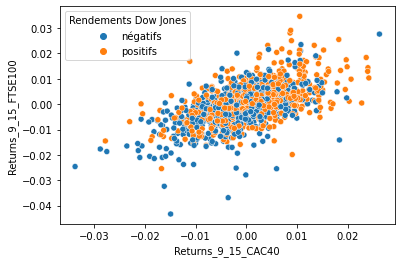

In [10]:
ax = sns.scatterplot(x="Returns_9_15_CAC40", y="Returns_9_15_FTSE100", data=data_train,hue="Returns_DJ_positive")
leg_handles = ax.get_legend_handles_labels()[0]
ax.legend(leg_handles, ["négatifs", "positifs"], title='Rendements Dow Jones')

Tout d'abord, on peut remarquer une certaine linéarité dans le graphe montrant ainsi une corrélation positive entre le FTSE100 et le CAC40. De plus la couleur des points, nous indiquant le signe futur des rendements du Dow Jones semble indiquer un certain "pattern". En effet la concentration des points oranges est plus importante dans le cadran haut-droite, tandis que la concentration des points bleus est plus importante dans  le cadran bas-gauche. Cela confirme donc une hypothèse assez intuitive, lorsque les marchés européens se portent bien, les futurs rendements du Dow Jones ont tendance à être également positifs. La fonction pairplot du package seaborn nous permet de représenter l'ensemble des combinaisons de graphes sur une même figure :

In [11]:
All = X_train.copy(deep=True)  #copier X_train sans qu'une modification de la copie modifie X_train
All["Returns_DJ"] = y_trainReg
All["Returns_DJ_positive"] = y_trainClassif

In [ ]:
sns.pairplot(All, hue = "Returns_DJ_positive")


On remarque ici de très fortes corrélations, notamment entre le DAX et le CAC qui forment une droite clairement linéaire. A l'inverse pour les indices asiatiques, les corrélations sont moins évidentes et les graphes ressemblent surtout à des amas de points dans lesquels il est assez difficile de repérer une quelconque droite.

On peut également regarder les fonctions de densité, permettant de comparer la différence de densité des indices lorsque les rendements du Dow Jones sont positifs et lorsqu'ils sont négatifs. A l'exception du SSE_Composite pour lesquels les deux densités se superposent, on remarque pour l'ensemble des autres indices un décalage vers la droite de leur densité lorsque les rendements à venir du Dow Jones sont positifs.

In [12]:
# Création du dataset permettant de former le boxplot ci-dessous

df=[]
Var_expli = Var[1:]
for i in range(len(Var_expli)):
    data = pd.DataFrame(data_train[[Var_expli[i],"Returns_DJ_positive"]]).assign(Returns_name = Var_expli[i])
    data=data.rename(columns = {Var_expli[i]:'Returns_value'})
    df.append(data)

all_df = pd.concat(df)

In [13]:
all_df

,Returns_value,Returns_DJ_positive,Returns_name
0,0.014607,1,Returns_SSE_Composite
1,0.014607,0,Returns_SSE_Composite
2,-0.005468,1,Returns_SSE_Composite
3,0.006031,0,Returns_SSE_Composite
4,-0.003757,0,Returns_SSE_Composite
...,...,...,...
1505,-0.006576,0,Returns_9_15_FTSE100
1506,-0.006576,1,Returns_9_15_FTSE100
1507,-0.014242,1,Returns_9_15_FTSE100
1508,0.023517,0,Returns_9_15_FTSE100


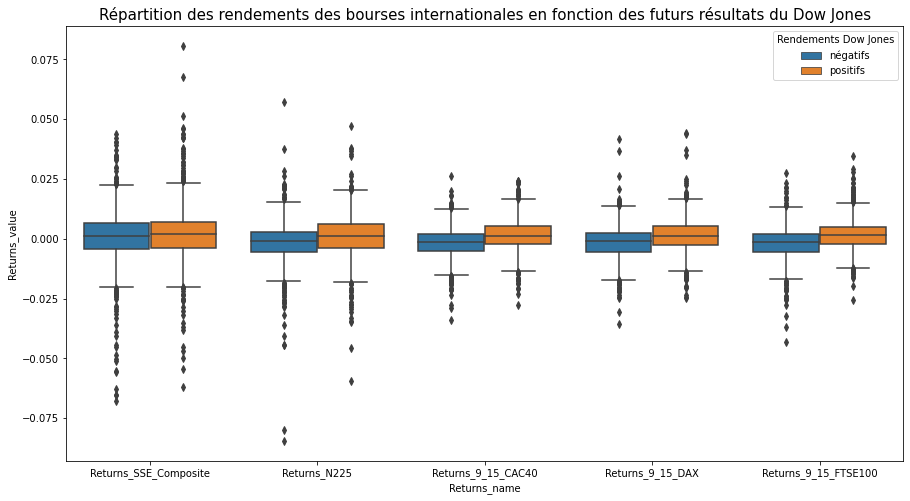

In [14]:
plt.figure(figsize=(15, 8))
ax=sns.boxplot(data = all_df,x="Returns_name", y="Returns_value", hue="Returns_DJ_positive")
ax.set_title("Répartition des rendements des bourses internationales en fonction des futurs résultats du Dow Jones", fontsize=15)
leg_handles = ax.get_legend_handles_labels()[0]
ax.legend(leg_handles, ["négatifs", "positifs"], title='Rendements Dow Jones')


Assez logiquement les résultats correspondent aux précédentes observations faites sur les densités, à l'exception du SSE_Composite, il y a un décalage des boxplot vers des valeurs positives lorsque les rendements du Dow Jones sont eux mêmes positifs.

In [15]:
# Création du dataset pour former le graphe ci-dessous

Var_expli_classif = []
for i in range(len(Var_expli)): Var_expli_classif.append(Var_expli[i] + "_positive")

df=[]
for i in range(len(Var_expli_classif)):
    data = pd.DataFrame(data_train[[Var_expli_classif[i],"Returns_DJ_positive"]]).assign(Returns_name = Var_expli_classif[i])
    data=data.rename(columns = {Var_expli_classif[i]:'Returns_value'})
    df.append(data)

all_df_classif = pd.concat(df)
all_df_classif

,Returns_value,Returns_DJ_positive,Returns_name
0,1,1,Returns_SSE_Composite_positive
1,1,0,Returns_SSE_Composite_positive
2,0,1,Returns_SSE_Composite_positive
3,1,0,Returns_SSE_Composite_positive
4,0,0,Returns_SSE_Composite_positive
...,...,...,...
1505,0,0,Returns_9_15_FTSE100_positive
1506,0,1,Returns_9_15_FTSE100_positive
1507,0,1,Returns_9_15_FTSE100_positive
1508,1,0,Returns_9_15_FTSE100_positive


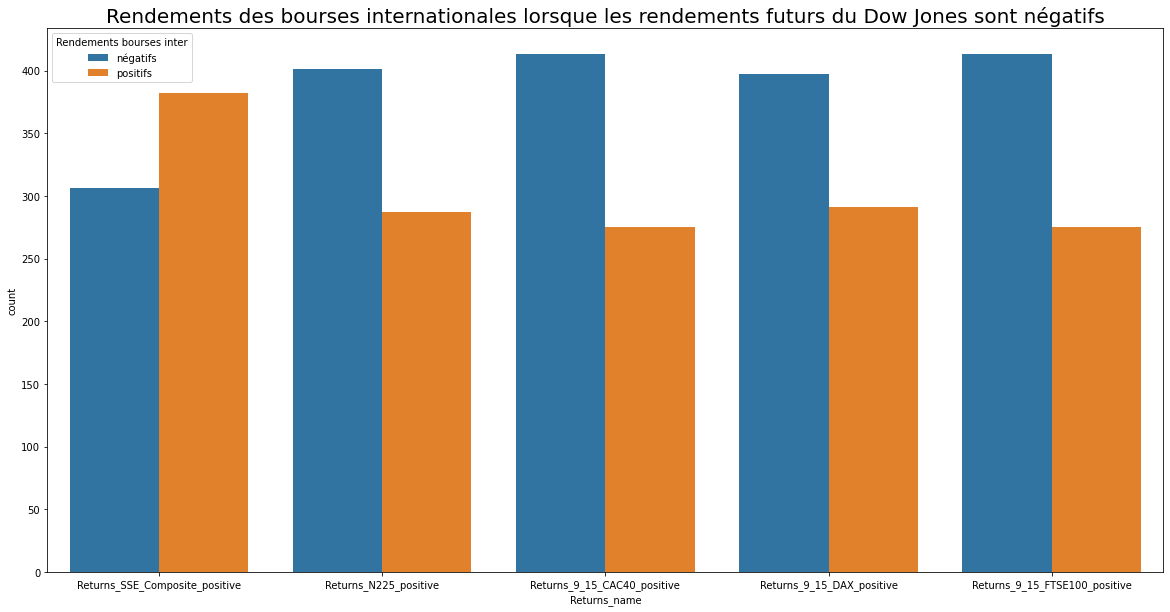

In [16]:
plt.figure(figsize=(20, 10))
ax=sns.countplot(data= all_df_classif[all_df_classif["Returns_DJ_positive"] == 0], x = "Returns_name",hue="Returns_value")
leg_handles = ax.get_legend_handles_labels()[0]
ax.legend(leg_handles, ["négatifs", "positifs"], title='Rendements bourses inter')
ax.set_title("Rendements des bourses internationales lorsque les rendements futurs du Dow Jones sont négatifs", fontsize=20)
plt.show()

On a ici le signe des indices internationaux quand les rendements du Dow Jones sont négatifs. On remarque très clairement que les rendements des autres indices ont tendance à être d'avantages négatifs que positifs. Exception encore une fois pour le SSE_Composite, attention cependant, même si les rendements sont clairement plus positifs, cela n'indique pas nécessairement une corrélation négative, étant donné que la proportion générale des rendements positifs est plus importante que les négatifs pour cet indice.

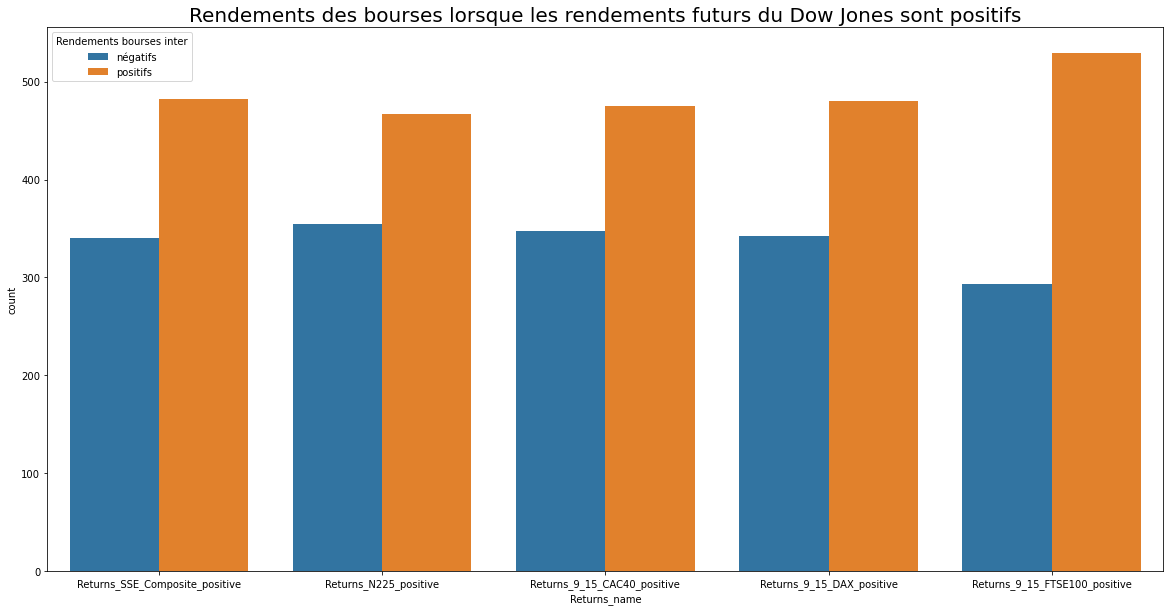

In [17]:
plt.figure(figsize=(20, 10))
ax=sns.countplot(data= all_df_classif[all_df_classif["Returns_DJ_positive"] == 1], x = "Returns_name",hue="Returns_value")
leg_handles = ax.get_legend_handles_labels()[0]
ax.legend(leg_handles, ["négatifs", "positifs"], title='Rendements bourses inter')
ax.set_title("Rendements des bourses lorsque les rendements futurs du Dow Jones sont positifs", fontsize=20)
plt.show()

Lorsque cette fois on regarde la répartition quand les rendements du Dow Jones sont positifs, on observe une tendance inverse, à part pour le SSE_Composite dont les proportions sont globalement équivalentes au graphe précédent. La corrélation la plus claire revient au FTSE100 pour lequel pratiquement 2/3 des rendements sont positifs lorsque les futurs rendements du Dow Jones le sont également.

# Prédictions <a class="anchor" id="3"></a>

## Choix des variables <a class="anchor" id="31"></a>

### Description des 3 méthodes de sélections de variables <a class="anchor" id="311"></a>

En machine learning on distingue souvent les méthodes de sélection de variables en 3 catégories :

* Filter method: on opère directement sur le jeu de données à l'aide d'une certaine mesure que l'on doit spécifier, on obtient une pondération, un classement ou un ensemble de variables en sortie.


* Wrapper method: on effectue une recherche dans l’espace des sous-ensembles de variables, guidée par le résultat du modèle, par exemple les performances en validation croisée sur les données d’apprentissage. Le temps de calcul est de fait plus important que les méthodes de filtre.


* Embedded method: on sélectionne les variables à partir des méthodes de sélection de features intégrées aux algrithmes (ce qui n'existe pas toujours en fonction des modèles).

Dans cette partie, on va donc tenter de choisir au mieux les variables pertinentes en utilisant plusieurs types de méthodes.

### Filter method : Pearson Correlation <a class="anchor" id="312"></a>

In [1]:
corrMatrix = data_train[Var].corr()
plt.figure(figsize=(10, 10))   #Pour régler la taille de notre matrice de corrélation
ax = sns.heatmap(corrMatrix, annot=True,cmap='BuGn',fmt = '.1%', square=1, linewidth=1.0)   #On ajoute des params pour mettre en pourcentage (plus lisible)
bottom, top = ax.get_ylim()          #Pour régler le problème de matplotlib 3.1.1 qui coupe la matrice de corrélation
ax.set_ylim(bottom +0.5, top-0.5)
plt.show()


NameError: name 'data_train' is not defined

Le coefficient de Pearson, aussi appelé coefficient de corrélation linéaire, évalue la relation linéaire entre deux variables. On calcule le coefficient de Pearson entre une variable X et Y de la manière suivante :

$\rho = \frac{\text{cov}(X,Y)}{\sigma_x \sigma_y}$

Le coefficient est compris entre -1 et 1. Plus le coefficient est proche de 1, plus la relation linéaire positive entre les variables est forte et plus il est proche de -1 plus la relation linéaire négative est forte. Un coefficient proche de 0 indiquant une relation linéaire faible. On l'exprime ici en pourcentages pour plus de lisibilité.

A partir de ce coefficient on peut effectuer un classement qui va de la variable la plus corrélée linéairement aux rendements du Dow Jones à la variable la moins corrélée :

1. FTSE100 avec un coefficient de 0.336
2. CAC40 avec un coefficient de 0.286
3. DAX avec un coefficient de 0.259
4. N225 avec un coefficient de 0.180
5. SSE_Composite avec un coefficient de 0.092

Il est également intéressant de remarquer la forte corrélation entre les indices européens, avec une corrélation atteignant presque les 80% entre le DAX et le CAC. La présence de variables trop fortement corrélées entres elles dans les modèles peut être contre-productif, il est donc important de considérer d'autres méthodes de sélection de variables.

### Filter method : test ANOVA <a class="anchor" id="313"></a>

Le test ANOVA permet de mesurer la dépendance entre une variable quantitative et une variable qualitative. Dans notre cas, on mesure donc la dépendance entre les rendements des bourses non-américaines avec la variable qualitative Returns_DJ_positive qui nous retourne 1 si les rendements sont positifs et 0 si ils sont négatifs.

L'idée du test est de vérifier si la moyenne de la variable quantitative est homogène sur l'ensemble des modalités de la variable qualitative.

Le test nous retourne la statistique F de Fisher nous permettant de déterminer si on peut rejeter l'hypothèse H0 d'égalité des moyennes.

In [19]:
from sklearn.feature_selection import f_classif

f_classif(X_train, y_trainClassif)

(array([  6.5263368 ,  29.44349794,  79.81072607,  67.27352493,
        100.62777359]),
 array([1.07263660e-02, 6.69824893e-08, 1.17254616e-18, 5.00502619e-16,
        5.72064826e-23]))

L'ensemble des p-values sont inférieurs à 0.05 nous permettent de rejeter l'hypothèse d'égalité des moyennes pour l'ensemble des variables quantitatives. On peut tout de même noter le classement qui se dégage, de la variable la plus dépendante, à la moins dépendante selon la statistique de test : 
1. FTSE100
2. CAC40
3. DAX
4. N225
5. SSE_Composite

In [20]:
list(X_train.columns)

['Returns_SSE_Composite',
 'Returns_N225',
 'Returns_9_15_CAC40',
 'Returns_9_15_DAX',
 'Returns_9_15_FTSE100']

Pour savoir à quel indice correspond chaque coeffcient voici pour rappel l'ordre dans lequel sont affichés les résultats pour chaque vecteur.

### Wrapper method : Recursive Feature Elimination (RFE) <a class="anchor" id="314"></a>

Description du fonctionnement de l'algorithme RFECV - Recursive Feature Elimination Cross Validation :

1- On détermine le nombre de variables minimum à sélectionner (params : min_features_to_select) ainsi que le nombre de variables à supprimer à chaque itération (params : step). Pour simplifier l'explication, on va considérer que step = 1.


2- On calcule le score de cross-validation de notre modèle avec l'ensemble de nos variables.


3- On enlève la variable la moins importante (l'importance étant déterminé par l'attribut .coef_ ou .feature_importances_ du modèle).


4- On réitère les étapes 2 et 3 en recalculant le score de cross-validation sans la variable que l'on vient d'enlever puis on enlève la prochaine variable la moins importante.


5- On s'arrête une fois que l'on atteint le nombre minimum de variables à sélectionner


6- On sélectionne pour finir le sous-ensemble de variables donnant le meilleur score de cross-validation


Remarque : cette algorithme ne marche pas avec tous les modèles étant donné que certains d'entre eux ne possède ni d'attributs .coef_ ni d'attributs .feature_importances_ (modèle KNN par exemple)

#### RFECV avec modèle linéaire <a class="anchor" id="3141"></a>

In [22]:
from sklearn.linear_model import LinearRegression
model = LinearRegression()
model.fit(X_train, y_trainReg)

model.coef_

array([0.02481282, 0.08727084, 0.11140483, 0.08328022, 0.20156368])

Pour le modèle linéaire par exemple, le plus petit coefficient $\beta$ est celui du SSE_Composite, c'est donc celui-ci qui sera supprimé en premier dans l'algorithme. (A noter que pour connaître la 2ème variable qui sera supprimée il faut recalculer les coefs du modèle sans le SSE_Composite)

In [23]:
from sklearn.feature_selection import RFECV
from sklearn.svm import SVR

selector = RFECV(LinearRegression(), 
                 step = 1, 
                 min_features_to_select =1, 
                 cv=5)


selector.fit(X_train, y_trainReg)
selector.ranking_

array([2, 1, 1, 1, 1])

In [24]:
selector.grid_scores_

array([0.04132099, 0.08059919, 0.08031923, 0.09179793, 0.08916126])

Pour le modèle conservant toutes les variables, on trouve un R2 de 8,92% (**dernière** position du vecteur). Lorsqu'on enlève la variable la moins pertinente, on obtient sur le nouveau modèle un score de 9,18%, il s'agit de la variable étant en dernière position dans le vecteur ranking (position 2), soit Returns_SSE_Composite. Lorsqu'on retire d'autres variables, les R2 sont plus faibles. Ainsi le ranking de toutes les autres variables est de 1.

Selon le RFE sur la régression linéaire on devrait donc retirer le SSE_Composite vu que le R2 obtenu est meilleur quand on enlève cette variable. Mais qu'il s'empire lorsque l'on en retire d'autres.

#### RFECV avec régression logistique Lasso <a class="anchor" id="3142"></a>

La régression logistique est similaire à la régression linéaire pour des problèmes de classification binaire, on reviendra dessus plus en détail dans les prédictions de la prochaine partie.

On commence par sélectionner les meilleurs paramètres de notre modèle avec la fonction GridSearchCV (on reviendra dessus plus en détail un peu plus tard dans l'analyse) puis applique la méthode RFECV sur notre régression logistique.

Avant de faire notre sélection de variable grâce à une régression logistique LASSO (norme 1), commençons par déterminer le paramètre de pénalisation C=1/λ optimal

In [25]:
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV


param_grid = {"C": np.logspace(-3, 3, num=7)}

grid = GridSearchCV(LogisticRegression( penalty='l1', solver='liblinear', random_state=0), param_grid, cv=5)
grid.fit(X_train, y_trainClassif)
grid.best_params_

{'C': 10.0}

In [26]:
model = LogisticRegression(C=grid.best_params_["C"], penalty='l1', solver='liblinear')
model.fit(X_train, y_trainClassif)
model.coef_

array([[ 3.75475569, 19.26476432, 23.53601142, 19.31216718, 39.79685969]])

SSE_Composite possède le coefficient plus faible, il sera donc retiré en premier de l'algorithme


In [27]:
selector = RFECV(LogisticRegression(C=grid.best_params_["C"], penalty='l1', solver='liblinear'), 
                 step = 1, 
                 min_features_to_select =1, 
                 cv=5)

selector.fit(X_train, y_trainClassif)
selector.ranking_

array([2, 1, 1, 1, 1])

In [28]:
selector.grid_scores_

array([0.61258278, 0.62317881, 0.62384106, 0.63377483, 0.62781457])

Avec un modèle conservant l'ensemble des variables on obtient un score de précision de 62.8%, en enlevant la variable avec le coefficient le plus faible (SSE_Composite), on obtient un meilleur score de l'ordre de 63.4%. En retirant d'autres variables les scores de précisions sont moins bons.

Rappel concernant le score d'accuracy :

$Accuracy~score = \frac{Nombre~de~prédictions~correctes}{Nombre~total~de~prédictions} = \frac{VP + VN}{VP + VN + FP + FN}$

Selon le RFECV sur la régression logistique avec pénalisation Lasso, on doit retirer uniquement la variable SSE_Composite

## Embedded method : Select From Model <a class="anchor" id="315"></a>

La méthode Select From Model consiste à sélectionner les variables directement à partir des coefficients du modèle. C'est donc encore une fois une technique qui doit faire appelle à un estimateur qui développe soit des coefficients (ex : modèle linéaire), soit qui calcule l'importance des variables pendant leur création (ex : random forest).

Description des étapes de l'algorithme en détail :

1- On calcule les coefficients


2- On définit l'importance en faisant la norme 1 des lignes de la matrice de transformation (i.e  importances = np.linalg.norm(selector.estimator_.coef_, axis=0, ord=1) ). Dans le cas ou les labels "y" sont des réels, il s'agit simplement de faire la valeur absolue des coefficients de chaque features.


3- On calcule la moyenne du vecteur norme : mean = np.mean(importances) (on peut choisir un autre indicateur que le mean en modifiant le threshold)


4- Si importances > mean alors la variable est sélectionnée

#### Select From Model avec régression logistique Lasso <a class="anchor" id="3151"></a>

In [29]:
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier

embeded_lr_selector = SelectFromModel(LogisticRegression(C=grid.best_params_["C"], penalty='l1', solver='liblinear'), threshold='mean')
embeded_lr_selector.fit(X_train, y_trainClassif)

embeded_lr_selector.get_support()

array([False, False,  True, False,  True])

Il faudrait donc garder uniquement le FTSE100 et le CAC40 selon cet algo. On peut le reproduire facilement à la main en suivant les étapes ci-dessus.

In [30]:
importances = np.linalg.norm(embeded_lr_selector.estimator_.coef_, axis=0, ord=1)
importances

array([ 3.74594522, 19.25873972, 23.21498771, 19.61132064, 39.86137682])

In [31]:
mean = np.mean(embeded_lr_selector.estimator_.coef_)

In [32]:
importances > mean

array([False, False,  True, False,  True])

On retrouve bien les mêmes résultats que l'algorithme en le faisant à la main. 

Selon la régression logistique Lasso, les variables les plus pertinentes sont dans l'ordre :

1. FTSE100
2. CAC40
3. DAX
4. N225
5. SSE_Composite

#### Select from model avec Random Forest et l'OOB ERROR <a class="anchor" id="3152"></a>

In [34]:
from sklearn.ensemble import RandomForestClassifier

m = RandomForestClassifier(n_estimators=500, random_state=0, oob_score=True)
m.fit(X_train, y_trainClassif)

RF_selector = SelectFromModel(m, max_features=5)
RF_selector.fit(X_train, y_trainClassif)

RF_selector.get_support()

array([False,  True, False, False,  True])

Selon cet algorithme il faudrait conserver uniquement les rendements du N225 et du FTSE100. On peut s'intéresser au classement de chaque variable selon l'OOB error :

In [35]:


def rf_feat_importance(m, df):
    return pd.DataFrame({'cols':df.columns, 'imp':m.feature_importances_}
                       ).sort_values('imp', ascending=False)
fi = rf_feat_importance(m, X_train)
fi

,cols,imp
4,Returns_9_15_FTSE100,0.222950
1,Returns_N225,0.203064
2,Returns_9_15_CAC40,0.199791
3,Returns_9_15_DAX,0.190089
0,Returns_SSE_Composite,0.184107


Si on décide de se baser sur l'erreur OOB donnée par Random Forest et qu'on décide par exemple de conserver 4 variables il faudrait retirer les rendements du SSE_Composite.

### Choix final <a class="anchor" id="316"></a>

A partir de l'ensemble des méthodes ci-dessus nous avons décidé de retirer uniquement la variable Returns_SSE_Composite, pour les raisons suivantes : 

* C'est la variable la moins dépendante des rendements du Dow Jones selon la corrélation linéaire de Pearson
* C'est la variable la moins dépendante des rendements du Dow Jones selon le test ANOVA


* La variable empire le R2 de la régression linéaire lorsqu'on l'ajoute
* La variable empire le score de précision de la régression logistique avec pénalisation Lasso lorsqu'on l'ajoute
* En enlevant d'autres variables supplémentaires les scores empirent


* La variable possède la plus faible importance selon les coefficients de la régression logistique
* La variable possède la plus faible importance selon l'importance donnée par l'erreur OOB

In [36]:
VarExpli = ["Returns_9_15_FTSE100", "Returns_9_15_CAC40", "Returns_N225", "Returns_9_15_DAX"]
X_trainOpti = data_train[VarExpli]
X_testOpti = data_test[VarExpli]

## Classification <a class="anchor" id="32"></a>

In [37]:
# Préparation du tableau récapitulatif final

Number_models = 10
Total_models = {}
Total_best_params =  {}
Total_val_score = {}
Total_test_score = {}
Total_puissance_val_score = {}
Total_puissance_test_score = {}

### 1er modèle : CART <a class="anchor" id="321"></a>

Le modèle CART (Classification And Regression Trees) permet de faire de la prédiction à partir d'un arbre de décision que l'on construit à partir de nos observations. La construction d'un arbre se fait en 3 étapes :

1. Construction de l'arbre maximal

2. Elagage

3. Sélection finale

Les divisions de l'abre se font à partir de questions binaires de la forme $X\leq a~?$ . L'idée pour choisir ces divisions et de toutes les tester et de retenir la meilleure selon un critère. Ce critère il s'agit de l'information gain. On veut donc trouver la meilleure combinaison (variable, seuil) qui maximine l'Information Gain IG(j,t) avec j représentant la variable $X_j$ et t le seuil.

Dans le cadre de la classification, il nous faut d'abord introduire les notions d'indices de Gini ou d'indices d'Entropy, ainsi que les notations dont nous aurons besoin :

On considère un noeud N, qui n'est rien d'autre qu'un sous ensemble de notre échantillon. De plus introduisons un le noeud gauche $N_L$ ainsi que le noeud droite $N_R$ avec : 

$N_L(j,t) = \{x \in N : x < t\}$ et $N_R(j,t) = \{x \in N : x \geq t\}$ 

De plus on note la distribution de chaque classe avec : $p_N = (p_{N,1},...,p_{N,K})$

On peut désormais définir l'indice de Gini G, ainsi que l'indice d'Entropy H :

$G(N) = G(p_N) = \sum_{k=1}^K p_{N,k}(1-p_{N,k}) = 1- \sum_{k=1}^K p_{N,k}^2$

$H(N) = H(p_N) = -\sum_{k=1}^K p_{N,k}log(p_{N,k})$



Lorsqu'un noeud est pure c'est à dire lorsqu'un noeud est entièrement représenté par un certain label $y_i$, alors $p_{N,i}=1$ et dans ce cas les deux indices sont nulles.

On définit enfin l'information gain qu'on va chercher à maximiser à chaque split : 

$IG(j, t) = I(N) - \frac{|N_L(j,t)|}{|N|}G(N_L(j,t)) - \frac{|N_R(j,t)|}{|N|}G(N_R(j,t)) $

On a pris comme exemple ici l'indice de Gini mais la formule est équivalent pour l'indice d'Entropy.


#### Exemple d'arbre <a class="anchor" id="3211"></a>

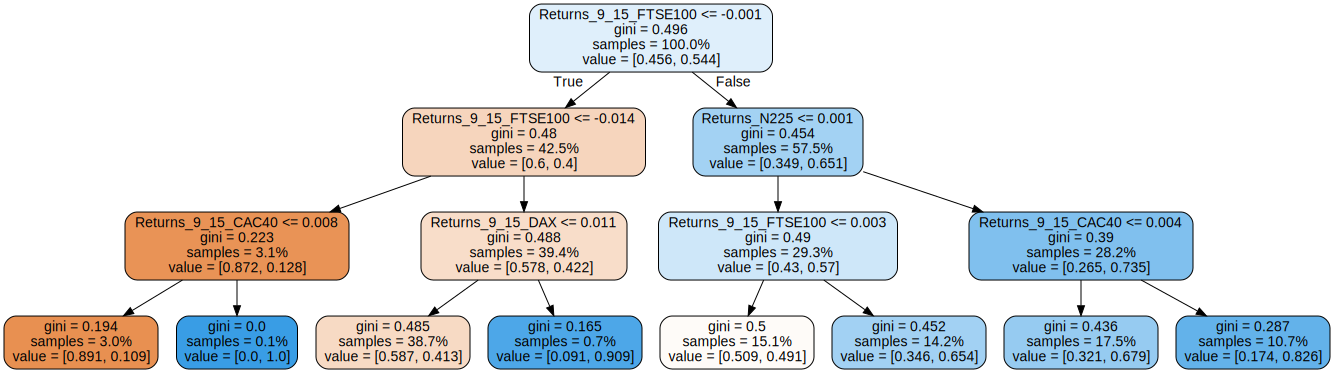

In [38]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn import tree

clf = tree.DecisionTreeClassifier(max_depth = 3)
clf = clf.fit(X_trainOpti, y_trainClassif)

dot_data = tree.export_graphviz(clf, out_file=None, 
                      feature_names=list(X_trainOpti.columns), 
                      filled=True, 
                      rounded=True,
                      proportion = True)

graph = graphviz.Source(dot_data)
graph

Pour plus de lisibilités, on se limite à un arbre de profondeur 3.

La première case nous donne tout d'abord la première question que l'on va se poser, qui est ici "Est-ce que les rendements du FTSE_100 sont inférieurs à -0.1% ?".


La deuxième ligne nous indique l'indice de Gini. Il est très simple de le retrouver ici, il suffit d'appliquer la formule à l'aide de la 4ème ligne ce qui nous donne : $1 - (0.456^2 + 0.544^2) = 0.496$


La troisième ligne la part du data set à qui l'on pose cette question, en l'occurrence vu que c'est la première c'est ici 100%.

Enfin, la quatrième ligne nous indique la répartition par classe (le vecteur $p_N$). Ainsi 45,6% du data set est dans la classe 0 et 54,4% dans la classe 1, c'est à dire que 45,6% des jours ont eu des rendements négatifs et 54,4% des jours des rendements positifs.

On observe que pour les observations dont la réponse à la première question est fausse, les 54,4% de jours avec rendements positifs passent désormais à 65,1% pour ce sous-ensemble du dataset qui correspond à 57,5% des données totales.

Si l'on suit l'ensemble du chemin de droite par exemple, ce qui correspond aux jours de bourses durant lesquels le rendement du FTSE100 est supérieur à -0.1%, celui du N225 supérieur à 0.1% et celui du CAC40 supérieur à 0.4%. Ce qui représente 10,7% des jours. Alors dans cette configuration 82.6% du temps, les rendements futurs du Dow Jones ont été positifs.



#### Choix de la profondeur optimal de l'arbre <a class="anchor" id="3212"></a>

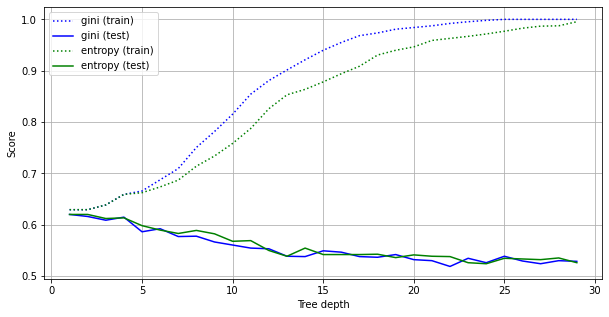

In [39]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

depths = np.arange(1, 30)
criteria = ["gini", "entropy"]

train_score = []
test_score = []
for criterion in criteria:
    train_score.append([])  
    test_score.append([])
    for depth in depths:
        clf = DecisionTreeClassifier(criterion=criterion, max_depth=depth)
        clf.fit(X_trainOpti, y_trainClassif)
        train_score[-1].append(clf.score(X_trainOpti, y_trainClassif))
        test_score[-1].append(cross_val_score(clf,X_trainOpti, y_trainClassif, cv=5).mean())

        
plt.figure(figsize=(10, 5))
colors = "bgrc"
for ic, criterion in enumerate(criteria):
    plt.plot(depths, train_score[ic], color=colors[ic], linestyle=':',
             label=criterion+" (train)")
    plt.plot(depths, test_score[ic], color=colors[ic], linestyle='-',
             label=criterion+" (test)")
plt.xlabel("Tree depth")
plt.ylabel("Score")
plt.grid()
plt.legend(loc="best")

Plus la profondeur de l'arbre augmente et plus le score sur le data set d'entraînement tend vers 1, tandis que celui sur le test set de test ne fait que baisser, l'écart qui se creuse entre les deux courbes au fur et à mesure est un signe d'overfitting.

In [40]:
criterion = "gini"
ic = np.where([c == criterion for c in criteria])[0][0]  # Index for gini impurity
idepth = np.argmax(test_score[ic])  # Index for best depth
depth = depths[idepth]  # Best depth
print("Best depth for {} criterion: {}.".format(criterion, depth))

best_CART_params = {}
best_CART_params["criterion"] = criterion
best_CART_params["max_depth"] = depth

best_CART = DecisionTreeClassifier(criterion=criterion, max_depth=depth)
val_score_CART = cross_val_score(best_CART,X_trainOpti, y_trainClassif, cv=5).mean()
print("Val score:", val_score_CART)



Best depth for gini criterion: 1.
Val score: 0.6198675496688741


L'arbre optimal, c'est à dire l'arbre donnant le meilleur score de validation, est obtenu pour le critère de Gini avec une profondeur d'abre de 1 pour un score de validation de 62%.

#### Visualisation de l'arbre optimal <a class="anchor" id="3213"></a>

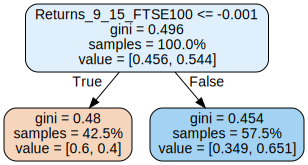

In [41]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn import tree
import graphviz # conda install python-graphviz

clf = best_CART.fit(X_trainOpti, y_trainClassif)

dot_data = tree.export_graphviz(clf, out_file=None, 
                      feature_names=list(X_trainOpti.columns), 
                      filled=True, 
                      rounded=True,
                      proportion = True)

graph = graphviz.Source(dot_data)
graph

Ici la prédiction est très  simple, on prédit que les rendements du Dow Jones sont positifs lorsque les rendements du FTSE100 de 9h à 15h sont supérieur à -0.1%. Sur l'ensemble du train set, 65,1% des rendements du Dow Jones sont positifs lorsque les rendements du FTSE dépasse ce seuil.

Ici -0.1% est arrondi, on peut obtenir le seuil exact de la manière suivante :

In [42]:
clf.tree_.threshold[clf.tree_.feature == 0]

array([-0.00066346])

On prédit donc des rendements positifs pour le Dow Jones lorsque les rendements du FTSE100 dépassse les -0.066%

#### Résultats sur le test set <a class="anchor" id="3214"></a>

In [43]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score


y_pred_CART = clf.predict(X_testOpti)


print(confusion_matrix(y_testClassif,y_pred_CART))
print(accuracy_score(y_testClassif, y_pred_CART))

[[109 104]
 [101 159]]
0.5665961945031712


On prédit 56,7% du temps la bonne tendance du Dow Jones.

Remarque : plutôt que d'utiliser la fonction predict, il est facile d'utiliser directement les résultats de l'arbre en appliquant le seuil vu précedemment.

In [44]:
from sklearn.metrics import  confusion_matrix, accuracy_score


y_pred_CART_manual = X_testOpti["Returns_9_15_FTSE100"] > -0.00066346

test_score_CART = accuracy_score(y_testClassif, y_pred_CART_manual)

print(confusion_matrix(y_testClassif,y_pred_CART_manual))
print(test_score_CART)

[[109 104]
 [101 159]]
0.5665961945031712


On retombe bien sur les mêmes résultats

In [45]:
# Pour effectuer un tableau récapitulatif à la fin

Total_models["CART"] = best_CART
Total_best_params["CART"] = best_CART_params
Total_val_score["CART"] = str(round(val_score_CART*100,2))+ " %"
Total_test_score["CART"] = str(round(test_score_CART*100,2))+ " %"

### 2ème modèle : Random Forest <a class="anchor" id="322"></a>

Le modèle Random forests est une combinaison des ces 3 éléments :

* Le modèle CART utilisé précedemment


* Le Bagging (contraction de Bootstrap Aggregation). Le principe est de créer un dataset différent pour nos différents classifieurs faibles. Pour ce faire on applique du bootstrap, on échantillone avec replacement notre dataset de taille N afin d'obtenir un nouveau dataset de taille N dans lequel chaque observation a une chance 1/N d'être tirée à chaque itération. Une fois les data set créés on entraîne nos classifieurs faibles sur chacun des datasets, puis on calcul la prédiction moyenne de donnée par nos classifieurs.


* Features bagging : lors de la sélection d'un point de division dans le modèle CART on considère uniquement un sous-ensemble aléatoire de nos variables afin d'éviter la corrélation entre les arbres.

#### Entraînement du modèle <a class="anchor" id="3231"></a>

Plutôt que de le faire manuellement comme avec le modèle CART on peut utiliser la fonction **GridSearchCV** qui selectionne directement pour nous les paramètres donnant le meilleur score de validation (parmi l'ensemble de paramètres qu'on lui précise au préalable dans param_grid)

In [46]:
from sklearn.ensemble import RandomForestClassifier

VarExpli_RF = ["Returns_9_15_FTSE100", "Returns_9_15_CAC40", "Returns_N225", "Returns_9_15_DAX"]
X_train_RF = data_train[VarExpli_RF]
X_test_RF = data_test[VarExpli_RF]


param_grid = { 
    'n_estimators': [200,500],
    'max_depth' : [3,4,5,6],
    'criterion' :['gini', 'entropy']
}
grid = GridSearchCV(RandomForestClassifier(random_state=0), param_grid, cv=5)  #random_state permet d'éviter d'avoir un résultat différent à chaque fois

grid.fit(X_train_RF, y_trainClassif)
val_score_RF = grid.best_score_
val_score_RF

0.6311258278145695

In [47]:
best_RF = grid.best_estimator_
best_RF_params = grid.best_params_
best_RF_params

{'criterion': 'entropy', 'max_depth': 4, 'n_estimators': 200}

Les paramètres ci-dessus permettent d'obtenir le meilleur score de validation qui atteint les 63,11%

#### Résultats sur le test set <a class="anchor" id="3232"></a>

In [48]:

y_pred_RF = best_RF.predict(X_test_RF)
test_score_RF = accuracy_score(y_testClassif, y_pred_RF)

print(confusion_matrix(y_testClassif,y_pred_RF))

print(classification_report(y_testClassif,y_pred_RF))
print(test_score_RF)

[[111 102]
 [ 92 168]]
              precision    recall  f1-score   support

           0       0.55      0.52      0.53       213
           1       0.62      0.65      0.63       260

    accuracy                           0.59       473
   macro avg       0.58      0.58      0.58       473
weighted avg       0.59      0.59      0.59       473

0.5898520084566596


On prédit 59% du temps la bonne tendance du Dow Jones

Remarque : Random Forest permet d'accéder aux probas de confiances associées à chaque prédiction :

In [49]:
y_pred_RF_prob = best_RF.predict_proba(X_test_RF)[:,1]
y_pred_RF_prob

y_pred_RF_opti = y_pred_RF_prob>0.60

print(confusion_matrix(y_testClassif,y_pred_RF_opti))

print(classification_report(y_testClassif,y_pred_RF_opti))
print(accuracy_score(y_testClassif, y_pred_RF_opti))

[[147  66]
 [133 127]]
              precision    recall  f1-score   support

           0       0.53      0.69      0.60       213
           1       0.66      0.49      0.56       260

    accuracy                           0.58       473
   macro avg       0.59      0.59      0.58       473
weighted avg       0.60      0.58      0.58       473

0.5792811839323467


Les probabilités correspondent simplement à la proportion de votes pour chaque arbre. En prenant un seuil de 0.5 on retombe donc sur 59% de score. On aura l'occasion d'utiliser ce seuil dans la partie stratégie d'investissement.

In [50]:
# Pour effectuer un tableau récapitulatif à la fin

Total_models["RF"] = best_RF
Total_best_params["RF"] = best_RF_params
Total_val_score["RF"] = str(round(val_score_RF*100,2))+ " %"
Total_test_score["RF"] = str(round(test_score_RF*100,2))+ " %"

### 3ème modèle : Régression logistique pénalisation Lasso <a class="anchor" id="323"></a>

La régression logistique est utilisée pour trouver la probabilité d’un événement. On veut determiner le succès ou l’échec d’un événement, ici, l'evolution positive ou negative du Dow Jones.

Les avantages de la regression logistique réside dans le fait de ne pas avoir besoin nécessairement de l'existence d'une relation linéaire entre les variables dépendantes et indépendantes. De plus, elle peut gerer différents types de relations.

La regression logistique modelise directement le parametre de la distribution Y|X = x. 

De plus,la logit transformation de la probabilité p(x) = P (Y = 1|X = x) est linéaire :

* $logit(p(x)) = log(\frac{p(x)}{1-p(x)}) = (x^T)*w + b$

Ensuite, on estime w et b avec les maximums de vraisemblance.

Il apparait que la penalisation Lasso donne des meilleurs resultats.


#### Entraînement du modèle <a class="anchor" id="3241"></a>

In [51]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

param_grid = {"C": np.logspace(-3, 3, num=7), "penalty": ['l1','l2']}

grid = GridSearchCV(LogisticRegression(solver='liblinear'), param_grid, cv=5)

grid.fit(X_trainOpti, y_trainClassif)
val_score_lasso = grid.best_score_
val_score_lasso

0.6337748344370862

In [52]:
best_lasso = grid.best_estimator_
best_lasso_params = grid.best_params_
best_lasso_params

{'C': 10.0, 'penalty': 'l1'}

Le meilleur  score de cross-validation est de 63,4% et il est obtenu avec les paramètres ci-dessus.

#### Résultats sur le test set  <a class="anchor" id="3242"></a>

In [53]:
y_pred_lasso = best_lasso.predict(X_testOpti)

test_score_lasso = accuracy_score(y_testClassif, y_pred_lasso)
print(confusion_matrix(y_testClassif,y_pred_lasso))
print(test_score_lasso)

[[ 89 124]
 [ 71 189]]
0.587737843551797


On obtient un score validation de 58,8% sur le data set de test.

In [54]:
# Pour effectuer un tableau récapitulatif à la fin

Total_models["LASSO"] = best_lasso
Total_best_params["LASSO"] = best_lasso_params
Total_val_score["LASSO"] = str(round(val_score_lasso*100,2))+ " %"
Total_test_score["LASSO"] = str(round(test_score_lasso*100,2))+ " %"

### 4ème modèle : KNN <a class="anchor" id="324"></a>

La méthode des K plus proche voisins (K nearest neighbours en anglais) est une méthode de classification se déroulant de 
la manière suivante :

* Pour chaque nouvelle observation, on aimerait prédire Y=0 ou Y=1.

* On choisit une distance qui nous permet de mesurer la distance entre la nouvelle observation et les points de notre Data Set.

* On selectionne les K plus proches voisins (selon la distance choisi) de la nouvelle observation.

* On determine la proportion des observation qui donne Y = 1.

On predira Y = 1 si cette proportion est superieure a 50%.

Un choix d'estimateur classique est le suivant : 

* $r_n(x) = \frac{1}{k} \sum_{i=1}^k Y_i(x)$

#### Entraînement du modèle <a class="anchor" id="3251"></a>

E:\Users\coren\anaconda3\lib\site-packages\sklearn\utils\validation.py:67: FutureWarning: Pass param_name=n_neighbors, param_range=[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


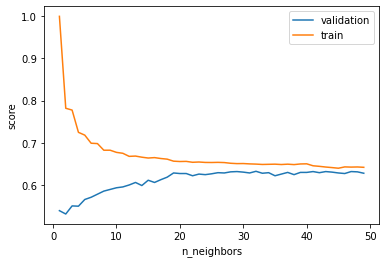

In [55]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import validation_curve

VarExpli_knn = ["Returns_9_15_FTSE100", "Returns_9_15_CAC40", "Returns_N225", "Returns_9_15_DAX"]
X_train_knn = data_train[VarExpli_knn]
X_test_knn = data_test[VarExpli_knn]

model = KNeighborsClassifier()
k = np.arange(1,50)
train_score, val_score = validation_curve(model, X_train_knn, y_trainClassif, 'n_neighbors', k, cv=5)

plt.plot(k, val_score.mean(axis=1), label='validation')
plt.plot(k, train_score.mean(axis=1), label="train")

plt.ylabel("score")
plt.xlabel("n_neighbors")
plt.legend()

L'overfitting est très clair pour les premières valeurs de k pour lesquelles le training score est très elevé comparé au validation score qui est très bas

In [56]:
from sklearn.neighbors import KNeighborsClassifier


param_grid = {"n_neighbors" : np.arange(20,70),
             "metric" : ["euclidean", "manhattan", "minkowski"]}

grid = GridSearchCV(KNeighborsClassifier(), param_grid, cv=5)

grid.fit(X_train_knn, y_trainClassif)
val_score_knn = grid.best_score_
val_score_knn


0.6370860927152318

In [57]:
best_knn = grid.best_estimator_
best_knn_params = grid.best_params_
best_knn_params

{'metric': 'euclidean', 'n_neighbors': 66}

Le score de validation maximal est de 63,7% et est obtenu avec les paramètres ci-dessus

#### Bagging avec KNN <a class="anchor" id="3252"></a>

In [58]:
from sklearn.ensemble import BaggingClassifier

best_knn_bagging = BaggingClassifier(base_estimator = best_knn, 
                         n_estimators = 100, 
                         random_state = 0)


best_knn_bagging.fit(X_train_knn, y_trainClassif)
cross_val_score(best_knn_bagging, X_train_knn, y_trainClassif, cv=5).mean()

0.6331125827814569

Appliquer une méthode de bagging sur notre modèle KNN optimal semble diminuer le score de cross validation, 
passant en effet de 63,7% à 63.3%, on décide donc de ne pas conserver cette technique.

#### Résultats sur le test set <a class="anchor" id="3253"></a>

In [59]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
y_pred_knn = best_knn.predict(X_test_knn)

test_score_knn = accuracy_score(y_testClassif, y_pred_knn)
print(confusion_matrix(y_testClassif,y_pred_knn))
print(test_score_knn)

[[106 107]
 [ 86 174]]
0.5919661733615222


On prédit 59,2% du temps la bonne tendance du Dow Jones

In [60]:
# Pour effectuer un tableau récapitulatif à la fin

Total_models["KNN"] = best_knn
Total_best_params["KNN"] = best_knn_params
Total_val_score["KNN"] = str(round(val_score_knn*100,2))+ " %"
Total_test_score["KNN"] = str(round(test_score_knn*100,2))+ " %"

### Choix du meilleur modèle de classification <a class="anchor" id="325"></a>

Avec un score de validation de 63,7% on sélection le modèle knn pour la classification.

In [61]:
BestClassif = max(Total_val_score, key=Total_val_score.get)
BestClassifModel = Total_models[BestClassif]

## Régression <a class="anchor" id="33"></a>

L'idée de cette partie est d'utiliser des modèles de régression pour répondre à notre objectif. Notre but étant toujours de faire de la classification en prédisant "1" lorsque l'on veut investir et "0" sinon, une partie "score de classification" sera effectuée pour chaque modèle. On prédira simplement "1" lorsque les rendements de la régression sont positifs et "0" sinon.

### 1er modèle : Modèle linéaire <a class="anchor" id="331"></a>

Le but de la régression simple (resp. multiple) est d'expliquer une variable Y à l'aide d'une variable X (resp.
plusieurs variables X1, ..., Xq).
On suppose l'existence d'une relation linèaire entre notre variable a expliquer et nos variables explicatives.

Pour estimer les differents coefficients de chaque variable explicative, on utilise la méthode des moindres carrées.


#### Entraînement du modèle <a class="anchor" id="3311"></a>

In [62]:
from sklearn.linear_model import LinearRegression


RegLin = LinearRegression()
RegLin.fit(X_trainOpti, y_trainReg)

cross_val_score(RegLin, X_trainOpti, y_trainReg, cv=5).mean()

0.091797934228077

Le coefficient de détermination R2 est de 9,2% pour le modèle linéaire

#### Résultats sur le test set <a class="anchor" id="3312"></a>

In [63]:
RegLin.score(X_testOpti, y_testReg)

0.12245125249864075

Le R2 sur le test set est de 12,2%

In [64]:
RegLin.coef_

array([0.21136776, 0.10292986, 0.09062216, 0.08502641])

In [65]:
RegLin.intercept_

0.0002599360512270663

#### Score de classification <a class="anchor" id="3313"></a>

In [66]:
from sklearn.model_selection import KFold

def ClassifWithReg_ScoreCV(model, seuil):
    kf5 = KFold(n_splits=5, shuffle=False)
    val_score=[]
    for train_index, valid_index in kf5.split(X_trainOpti): #5 itérations, 1 pour chaque combinaison de split train/validation
        
        X_trainCV, X_validCV = X_trainOpti.iloc[train_index], X_trainOpti.iloc[valid_index]
        y_trainReg_CV, y_validReg_CV = y_trainReg.iloc[train_index], y_trainReg.iloc[valid_index]
        y_validClassif_CV = y_trainClassif.iloc[valid_index]
        
        model.fit(X_trainCV, y_trainReg_CV)
        y_pred_reg = model.predict(X_validCV)
        y_pred_regClassif = y_pred_reg>seuil
        val_score.append(accuracy_score(y_validClassif_CV, y_pred_regClassif))
    return(np.mean(val_score))


val_score_LinearReg = ClassifWithReg_ScoreCV(RegLin, 0)
val_score_LinearReg

0.6298013245033113

Le score de classification est de 62.9% lorsque l'on prédit "1" quand les rendements de la régression linéaire sont positifs.

In [67]:
y_pred_reg = RegLin.predict(X_testOpti)


In [68]:
y_pred_regClassif = y_pred_reg>0

test_score_LinearReg = accuracy_score(y_testClassif, y_pred_regClassif)

print(confusion_matrix(y_testClassif,y_pred_regClassif))
print(test_score_LinearReg)



[[113 100]
 [ 97 163]]
0.5835095137420718


Le score sur le test set est de 58,3%

In [69]:
# Pour effectuer un tableau récapitulatif à la fin

Total_models["LinearReg>0"] = LinearRegression()
Total_best_params["LinearReg>0"] = ""
Total_val_score["LinearReg>0"] = str(round(val_score_LinearReg*100,2))+ " %"
Total_test_score["LinearReg>0"] = str(round(test_score_LinearReg*100,2))+ " %"

### 2ème modèle : SVM <a class="anchor" id="332"></a>

La régression par Machines à Vecteurs de Support (SVR) consiste à trouver la fonction f(x) qui a au plus
une déviation ε par rapport aux exemples d’apprentissage (xi, yi), pour i = 1, . . . , N , et qui est le plus plate possible. 

Cela revient à ne pas considérer les erreurs inférieures à ε et à interdire celles supérieures à ε. Maximiser la platitude de la fonction permet de minimiser la complexité du modèle qui influe sur ses performances en généralisation. 

En effet, la théorie de l’apprentissage permet de borner l’erreur de généralisation par une somme de deux termes : l’un dépendant de la complexité du modèle et l’autre dépendant de l’erreur sur les données d’apprentissage.

#### Entraînement du modèle <a class="anchor" id="3321"></a>

In [70]:
from sklearn.svm import SVR

param_grid = {'kernel' : ['linear', 'rbf'],'C': [1, 10, 100, 1000],'gamma': [0.001, 0.0001]}
param_grid={
    'kernel' : ['linear', 'rbf'],
    'C': [0.1,1,10],
    'epsilon': [0.0001, 0.001, 0.01,  0.1, 0.5, 1, 5, 10],
    'gamma': [0.001, 0.005, 0.1, 1, 5]
}

grid = GridSearchCV(SVR(), param_grid, cv=5)

grid.fit(X_trainOpti, y_trainReg)
grid.best_score_

0.10290309975681025

In [71]:
best_SVR = grid.best_estimator_
best_SVR_params = grid.best_params_
best_SVR_params

{'C': 0.1, 'epsilon': 0.0001, 'gamma': 1, 'kernel': 'rbf'}

Le R2 du modèle est de 10,3 soit un meilleur R2 que celui de la régression linéaire.

#### Résultats sur le test set <a class="anchor" id="3322"></a>

In [72]:
best_SVR.fit(X_trainOpti, y_trainReg)
best_SVR.score(X_testOpti, y_testReg)




0.11453474441602318

Alors que son R2 de validation est supérieur au modèle linéaire, celui-ci est inférieur sur les données de test. Malheuresement on ne peut utiliser nos résultats de test pour faire la sélection.

#### Score de classification <a class="anchor" id="3323"></a>

In [73]:
val_score_SVR = ClassifWithReg_ScoreCV(best_SVR, 0)
val_score_SVR

0.6364238410596027

Le score de validation est de 63,6% soit un score très proche au meilleure score de validation obtenu avec le knn dans la partie classification

In [74]:
y_pred_SVR = best_SVR.predict(X_testOpti)

y_pred_SVR_classif = y_pred_SVR>0

test_score_SVR = accuracy_score(y_testClassif, y_pred_SVR_classif)
print(confusion_matrix(y_testClassif,y_pred_SVR_classif))
print(test_score_SVR)


[[107 106]
 [ 93 167]]
0.5792811839323467


Le résultat sur le test set est nettement moins intéressant avec un score de 57,9%

In [75]:
# Pour effectuer un tableau récapitulatif à la fin

Total_models["SVR>0"] = best_SVR
Total_best_params["SVR>0"] = best_SVR_params
Total_val_score["SVR>0"] = str(round(val_score_SVR*100,2))+ " %"
Total_test_score["SVR>0"] = str(round(test_score_SVR*100,2))+ " %"

### 3ème modèle : Ridge <a class="anchor" id="333"></a>

Pour la regression de Ridge, on considère le problème d'optimisation suivant :


* $ \min_i{\sum_{i}^n{l(Y_i,⟨{w},{\phi(x_i)⟩})} + \frac{\lambda}{2} (||w||_2)^2}$

avec λ le paramètre de penalisation et l la fonction de perte quadratique.

On peut le réecrire de la manière suivante :

* $ \min_i{ (||y - Xw||_2)^2 + \lambda(||ww||_2)^2}$

C'est un problème strictement convexe et d'apres le "representer theorem" il existe $\alpha$ tel qu'on puisse ecrire $ w = X^T * \alpha$

Et enfin : 

* $ \alpha = (X^T*X + \lambda*I)^{-1} *y $

#### Entraînement du modèle <a class="anchor" id="3331"></a>

In [76]:
from sklearn.linear_model import Ridge


param_grid = {'alpha': np.arange(0, 0.2, 0.01) }


grid = GridSearchCV(Ridge(), param_grid, cv=5)

grid.fit(X_trainOpti, y_trainReg)
grid.best_score_

0.09982096074769735

In [77]:
best_ridge = grid.best_estimator_

best_ridge_params = grid.best_params_
best_ridge_params

{'alpha': 0.03}

Le R2 est de 10% et est obtenu avec les paramètres ci-dessus.

#### Résultats sur le test set <a class="anchor" id="3332"></a>

In [78]:
best_ridge.fit(X_trainOpti, y_trainReg)
best_ridge.score(X_testOpti, y_testReg)


0.12014135624089939

Le R2 sur le test set est de 12%.

##### Score de classification <a class="anchor" id="3333"></a>

In [79]:
val_score_ridge = ClassifWithReg_ScoreCV(best_ridge, 0)
val_score_ridge

0.6337748344370862

Le score de validation est de 63.4%

In [80]:
y_pred_ridge = best_ridge.predict(X_testOpti)

y_pred_ridge_classif = y_pred_ridge>0

test_score_ridge = accuracy_score(y_testClassif, y_pred_ridge_classif)
print(confusion_matrix(y_testClassif,y_pred_ridge_classif))
print(test_score_ridge)

[[106 107]
 [ 92 168]]
0.5792811839323467


Le score sur le test set est de 58%

In [81]:
# Pour effectuer un tableau récapitulatif à la fin

Total_models["ridge>0"] = best_ridge
Total_best_params["ridge>0"] = best_ridge_params
Total_val_score["ridge>0"] = str(round(val_score_ridge*100,2))+ " %"
Total_test_score["ridge>0"] = str(round(test_score_ridge*100,2))+ " %"

### Choix du meilleur modèle de régression  <a class="anchor" id="334"></a>

Avec un coefficient de détermination R2 égale à 10,3% sur la cross validation le modèle SVM est le plus performant. Bien que son score sur le set de test est inférieur au modèle linéaire on ne peut pas utiliser le test set pour faire un choix de modèle.

In [82]:
BestRegModel = best_SVR

# Définition des stratégies d'investissement <a class="anchor" id="4"></a>

Maintenant que nous avons une vision plus globale sur les différents scores de validation des modèles, l'idée de cette partie est d'estimer également les rendements potentiels que peuvent nous fournir nos modélisations en les comparant aux rendements long-terme. Car rien ne nous garantit pour l'instant que les scores que l'on obtient pourront permettre une superformance des rendements long-terme.

De plus, nous souhaitons analyser l'impact du choix des seuils sur les performances des investissements. En effet, nous avons pour l'instant considéré que le seuil optimal était à 0, c'est à dire que nous investissons lorsque l'on prédit des rendements positifs. L'idée est donc de voir l'impact d'un changement de seuil sur nos rendements.

Les codes de cette partie sont donc assez lourd, car nous allons programmer manuellement de la cross-validation, afin de calculer une moyenne des indicateurs, sur le même principe que le calcul du score de cross-validation. Par exemple, lorsque l'on va calculer les rendements long terme on ne va pas les calculer sur l'ensemble de la période de notre train set (i.e 2013 à 2018) mais on va les calculer sur 5 divisions équitables du train set, puis faire la moyenne. Afin de pouvoir comparer ces rendements avec les rendements de nos modèles calculer selon le même principe de cross-validation.

On va calculer par cross-validation, différents indicateurs :

* Accuracy score : déjà calculé via GridSearchCV $= \frac{Nombre~de~prédictions~correctes}{Nombre~total~de~prédictions} = \frac{VP + VN}{VP + VN + FP + FN}$ (Rmq : pour éviter la confusion avec la précision définie ci-dessous on ne fait la traduction de l'accuracy).


* Precision (ou encore valeur prédictive positive) : taux de réussite des prédictions positives = $\frac{VP}{VP + FP}$ Cet indicateur sera très important pour nous, car nous investissons lorsque notre prédiction est "positive" c'est à dire que lorsque l'on prédit "1", il s'agit donc du taux de réussite de nos investissements. Une précision de 70% signifiera que 70% de nos investissements journaliers ont eu des rendements positifs et sont donc rentables.


* Proportion des jours investit : part des jours durant lesquels on prédit des rendements positifs. Indicateur également important, car si nous atteignons une précision de 90% mais qu cela implique de devoir prédire 98% de "0" et 2% de "1" cela impliquera donc de devoir investir seulement 1 jour sur 50 ce qui n'est pas forcément le plus optimal.


* Rendements : rendements calculés avec les pertes ou bénéfices composés. Par exemple si on commence le premier jour d'investissement avec 100 euros et qu'on en retire 101 euros. Pour le deuxième jour on n'investit non pas 100 euros mais 101. A partir du premier jour il n'y a donc aucune rentrée ni sortie d'argent. On considèrera donc pour le calcul des rendements sur l'ensemble de la période que l'on a misé uniquement 100 euros.


* Rendements moyens sur les jours investit : on calcule les rendements journaliers moyens que l'on obtient lorsque l'on investit.

## Investissement à partir du meilleur modèle de classification <a class="anchor" id="41"></a>

In [83]:
def InvestissementsModelesClassif(model):
    kf5 = KFold(n_splits=5, shuffle=False)
    
    returns_par_cross_set = []
    returns_daily_mean = []
    part_investing_days = []
    precision = []
    
    for train_index, valid_index in kf5.split(X_trainOpti):
        X_trainCV, X_validCV = X_trainOpti.iloc[train_index], X_trainOpti.iloc[valid_index]
        y_trainClassif_CV, y_validClassif_CV = y_trainClassif.iloc[train_index], y_trainClassif.iloc[valid_index]
        y_validReg_CV = y_trainReg.iloc[valid_index]

        model.fit(X_trainCV, y_trainClassif_CV)
        y_pred = model.predict(X_validCV)
        
        cf = confusion_matrix(y_validClassif_CV, y_pred)
        precision.append(cf[1,1]/(cf[1,1]+cf[0,1]))
        
        gain_precedent = 100
        for i in range(len(y_pred)):
            if (y_pred[i]==1):
                gain_cumul = gain_precedent + (gain_precedent * list(y_validReg_CV)[i])
                gain_precedent = gain_cumul
                
        returns_par_cross_set.append(gain_cumul-100)
        returns_daily_mean.append(np.mean( y_validReg_CV[y_pred==1] ))
        part_investing_days.append(sum(y_pred==1)/len(y_pred))
        
    return(np.mean(returns_par_cross_set), np.mean(returns_daily_mean), np.mean(part_investing_days), np.mean(precision))

In [84]:
InvestissementsModelesClassif(BestClassifModel)

(45.38863582371241,
 0.0020593124951882092,
 0.5947019867549669,
 0.6544827595814494)

Ces résultats seront commentés plus en détail avec le tableau final. On observe tout de même 45,4% de rendements en moyenne sur les 5 splits pour le meilleur modèle de classification (knn). Cela va nous permettre de comparer avec les autres méthodes à venir.

## Investissement à partir des probabilités de Random Forest - Détermination seuil <a class="anchor" id="42"></a>

### Analyse graphique de l'impact du seuil sur les résultats d'investissements <a class="anchor" id="421"></a>

Pour rappel, l'attribut predict_proba du modèle RF renvoie la part des arbres de décisions qui ont voté pour la classe "1". Le modèle classique prédit alors "0" lorsque cette probabilité est inférieure à 0.5 et 1 lorsqu'elle est supérieure. Dans cette partie, nous allons faire bouger ce seuil de 0.5 pour voir l'impact sur nos différents indicateurs.

In [85]:
model = best_RF

kf5 = KFold(n_splits=5, shuffle=False)
ensemble_seuils = np.linspace(0.2,0.8,13)

#Total_(...) : score pour l'ensemble des seuils (score = moyenne des indicateurs  de chaque découpage de cross val)

Total_accuracy = []
Total_precision = []
Total_prop_invest = []  # Part des jours où l'on investit
Total_returns_invest = []  # Rendements moyen journalier de nos investissements
Total_gain_cumul_invest = []  # Miser avec les intérêts cumulés (sans rentré ni sortie d'argent)
Total_gain_long_terme = []  #Si on investit au début et qu'on se retire à la fin (moyenne des gains long terme sur chaque cross val set)

for seuil in ensemble_seuils : #1 itération = 1 seuil
    accuracy = []
    precision = []
    prop_invest = []
    returns_invest =[]
    gain_cumul_invest = []
    gain_long_terme_CV = []
    
    for train_index, valid_index in kf5.split(X_trainOpti): #5 itérations, 1 pour chaque combinaison de split train/validation
        
        X_trainCV, X_validCV = X_trainOpti.iloc[train_index], X_trainOpti.iloc[valid_index]
        y_trainClassif_CV, y_validClassif_CV = y_trainClassif.iloc[train_index], y_trainClassif.iloc[valid_index]
        y_validReg_CV = y_trainReg.iloc[valid_index]
        
        model.fit(X_trainCV, y_trainClassif_CV)
        y_pred_reg = model.predict_proba(X_validCV)[:,1]
        y_pred_regClassif = y_pred_reg>seuil
        
        accuracy.append(accuracy_score(y_validClassif_CV, y_pred_regClassif))

        
        cf = confusion_matrix(y_validClassif_CV, y_pred_regClassif)
        precision.append(cf[1,1]/(cf[1,1]+cf[0,1]))
        
        prop_invest.append(sum(y_pred_regClassif==1)/len(y_validClassif_CV))
        

        returns_invest.append(np.mean(y_validReg_CV[y_pred_regClassif==1])*100)   #On fait la moyenne des rendements journaliers 
                                                                              #lorsque l'on prédit des rendements positifs
        gain_precedent = 100
        for i in range(len(y_pred_regClassif)):
            if (y_pred_regClassif[i]==True): 
                gain_cumul = gain_precedent * (1 + list(y_validReg_CV)[i])
                gain_precedent = gain_cumul
                
        gain_cumul = gain_cumul  -100    
        gain_cumul_invest.append(gain_cumul)
        
        n = len(y_validClassif_CV)
        Open_val = data_train["Open_DJ"].iloc[valid_index]
        Close_val = data_train["Close_DJ"].iloc[valid_index]
        returns_lt = (list(Close_val)[n-1] - list(Open_val)[0])/list(Open_val)[0]
        gain_long_terme_CV.append((returns_lt * 100))
        
    Total_accuracy.append(np.mean(accuracy))
    Total_precision.append(np.mean(precision))
    Total_prop_invest.append(np.mean(prop_invest)*100)
    Total_returns_invest.append(np.mean(returns_invest))
    Total_gain_cumul_invest.append(np.mean(gain_cumul_invest))
    Total_gain_long_terme.append(np.mean(gain_long_terme_CV))

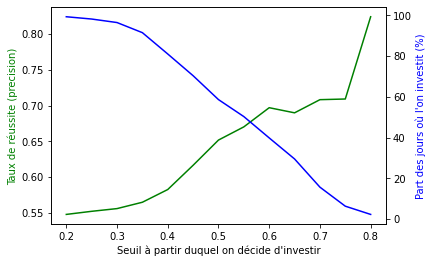

In [86]:
x=ensemble_seuils 
y1= Total_precision
y2 = Total_prop_invest


fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
ax1.plot(x, y1, 'g-')
ax2.plot(x, y2, 'b-')

ax1.set_xlabel("Seuil à partir duquel on décide d'investir")
ax1.set_ylabel("Taux de réussite (precision)"  , color='g')
ax2.set_ylabel("Part des jours où l'on investit (%)", color='b')

plt.show()

Les résultats de ce graphe sont plutôt logiques. Plus on augmente le seuil et plus notre confiance dans la prédiction augmente, ce qui se traduit en pratique dans les résultats par une augmentation de la précision. Cependant plus on augmente l'exigence de confiance et plus la part des jours durant lesquels on investit est faible.

Par exemple, si on prend le seuil classique de 0.5, on obtient une précision d'environ 65% et on investit sur environ 55% des jours.

En prenant le seuil 0.6, on obtient une précision d'environ 70% mais on n'investit seulement sur 40% des jours.

A partir du seuil de 0.6 on peut observer un plateau qui commence à se former, en effet en prenant le seuil de 0.65, la précision semble toujours être d'environ 70% mais on n'investit plus que sur 30% des jours.

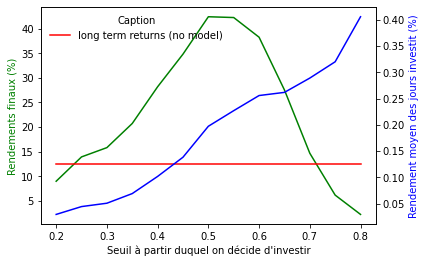

In [92]:
x=ensemble_seuils
y1 = Total_gain_cumul_invest

y2= Total_returns_invest

y3 = Total_gain_long_terme

fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
ax1.plot(x, y1, 'g-')
ax1.plot(x, y3, 'r-', label = "long term returns (no model)")

ax2.plot(x, y2, 'b-')

ax1.set_xlabel("Seuil à partir duquel on décide d'investir")
ax1.set_ylabel("Rendements finaux (%)"  , color='g')
ax2.set_ylabel("Rendement moyen des jours investit (%)", color='b')
ax1.legend(loc="upper left", title="Caption", frameon=False)

plt.show()

De manière assez logique, plus on est conservateur et plus les rendements moyens journaliers augmentent. Cependant les rendements globaux diminuent car cela implique de devoir miser sur un plus faible nombre de jours. On observe dans tous les cas que notre modèle offre des rendements clairement supérieur à l'investissement long-terme.

In [88]:
print("Les rendements obtenus avec un investissement long terme sont de "+ str(round(Total_gain_long_terme[0],2))+" %")

Les rendements obtenus avec un investissement long terme sont de 12.57 %


In [89]:
print("Le score d'accuracy max est de", round(max(Total_accuracy),3)*100,"%")
index = Total_accuracy.index(max(Total_accuracy))
print("Il est atteint pour le seuil :", ensemble_seuils[index])

Le score d'accuracy max est de 63.2 %
Il est atteint pour le seuil : 0.5


In [90]:
print("Les rendements maximums sont de :", round(max(Total_gain_cumul_invest),1), "%")
index = Total_gain_cumul_invest.index(max(Total_gain_cumul_invest))
print("Il sont atteints pour le seuil :", ensemble_seuils[index])

Les rendements maximums sont de : 42.4 %
Il sont atteints pour le seuil : 0.5


Les rendements maximums sont donc bien atteint pour le seuil de 0.5. On observe également que lorsqu

In [91]:
print("La precision maximale est de:", round(max(Total_precision),2), "%")
index = Total_precision.index(max(Total_precision))
print("Elle est atteinte pour le seuil de :", round(ensemble_seuils[index],3))
print("Pour obtenir un tel score l'investissement ne se fait que sur ", round(Total_prop_invest[index],2), "% des jours")
print("Ainsi les rendements sont relativements faibles (",round(Total_gain_cumul_invest[index],2) ,"%) car malgré une precision elevée on investit très rarement")

La precision maximale est de: 0.82 %
Elle est atteinte pour le seuil de : 0.8
Pour obtenir un tel score l'investissement ne se fait que sur  2.25 % des jours
Ainsi les rendements sont relativements faibles ( 2.26 %) car malgré une precision elevée on investit très rarement


On décide finalement en plus du seuil de 0.5, de faire une étude supplémentaire sur le seuil de 0.6 qui semble un bon compromis entre une meilleure précision que le modèle basique tout en n'étant pas trop conservateur en misant sur environ 40% des jours.

### Résultats pour le seuil sélectionné <a class="anchor" id="422"></a>

In [93]:
index = np.where(ensemble_seuils==0.6000000000000001)[0][0]
val_score_RF60 = Total_accuracy[index]

print(val_score_RF60)


0.6152317880794702


Le score d'accuracy total est plus faible qu'avec le seuil 0.5 car la valeur prédictive négative est beaucoup plus faible ($= \frac{VN}{VN + FN}$), vu qu'on exclu par précaution beaucoup de jours avec rendements positifs.

In [94]:
model.fit(X_trainOpti, y_trainClassif)
y_pred_reg = model.predict_proba(X_testOpti)[:,1]
y_pred_regClassif = y_pred_reg>0.6

test_score_RF60 = accuracy_score(y_testClassif, y_pred_regClassif)

print(test_score_RF60)

0.5792811839323467


Comme attendu le score d'accuracy sur le test set est de 57,9% ce qui est assez faible.

In [95]:
# Pour effectuer un tableau récapitulatif à la fin

Total_models["RF60"] = best_RF
Total_best_params["RF60"] = best_RF_params
Total_val_score["RF60"] = str(round(val_score_RF60*100,2))+ " %"
Total_test_score["RF60"] = str(round(test_score_RF60*100,2))+ " %"

## Investissement à partir du meilleur modèle de régression - Détermination seuil <a class="anchor" id="43"></a>

### Analyse graphique de l'impact du seuil sur les résultats d'investissements <a class="anchor" id="431"></a>

Cette fois-ci on décide de faire varier le seuil associé au score du modèle de régression. Dans la partie "régression" nous avions fixé ce seuil à 0, mais l'idée est encore une fois de voir si ce choix est optimal.

In [96]:
kf5 = KFold(n_splits=5, shuffle=False)

ensemble_seuils = np.linspace(-1/100,0.5/100,31)

#Total_(...) : score pour l'ensemble des seuils (score = moyenne des indicateurs  de chaque découpage de cross val)

Total_accuracy = []
Total_precision = []  
Total_prop_invest = []  # Part des jours où l'on investit
Total_returns_invest = []  # Rendements moyen journalier de nos investissements
Total_gain_cumul_invest = []  # Miser avec les intérêts cumulés (sans rentré ni sortie d'argent)
Total_gain_long_terme = []  #Si on investit au début et qu'on se retire à la fin (moyenne des gains long terme sur chaque cross val set)

for seuil in ensemble_seuils : #1 itération = 1 seuil
    accuracy = []
    precision = []
    prop_invest = []
    returns_invest =[]
    gain_cumul_invest = []
    gain_long_terme_CV = []
    
    for train_index, valid_index in kf5.split(X_trainOpti): #5 itérations, 1 pour chaque combinaison de split train/validation
        
        X_trainCV, X_validCV = X_trainOpti.iloc[train_index], X_trainOpti.iloc[valid_index]
        y_trainCV, y_validCV = y_trainReg.iloc[train_index], y_trainReg.iloc[valid_index]
        y_validClassifCV = y_trainClassif.iloc[valid_index]
        
        BestRegModel.fit(X_trainCV, y_trainCV)
        y_pred_reg = BestRegModel.predict(X_validCV)
        y_pred_regClassif = y_pred_reg>seuil
        
        accuracy.append(accuracy_score(y_validClassifCV, y_pred_regClassif))
        
        cf = confusion_matrix(y_validClassifCV, y_pred_regClassif)
        precision.append(cf[1,1]/(cf[1,1]+cf[0,1]))
        
        prop_invest.append(sum(y_pred_regClassif==1)/len(y_validClassifCV))
        

        returns_invest.append(np.mean(y_validCV[y_pred_regClassif==1])*100)   #On fait la moyenne des rendements journaliers 
                                                                              #lorsque l'on prédit des rendements positifs
        gain_precedent = 100
        for i in range(len(y_pred_regClassif)):
            if (y_pred_regClassif[i]==True): 
                gain_cumul = gain_precedent * (1 + list(y_validCV)[i])
                gain_precedent = gain_cumul
                
        gain_cumul = gain_cumul  -100    
        gain_cumul_invest.append(gain_cumul)
        
        n = len(y_validCV)
        Open_val = data_train["Open_DJ"].iloc[valid_index]
        Close_val = data_train["Close_DJ"].iloc[valid_index]
        returns_lt = (list(Close_val)[n-1] - list(Open_val)[0])/list(Open_val)[0]
        gain_long_terme_CV.append((returns_lt * 100))
        
    Total_accuracy.append(np.mean(accuracy))
    Total_precision.append(np.mean(precision))
    Total_prop_invest.append(np.mean(prop_invest)*100)
    Total_returns_invest.append(np.mean(returns_invest))
    Total_gain_cumul_invest.append(np.mean(gain_cumul_invest))
    Total_gain_long_terme.append(np.mean(gain_long_terme_CV))

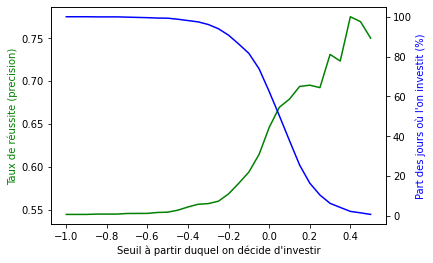

In [97]:
x=ensemble_seuils * 100  # *100 pour mettre en pourcentage
y1= Total_precision
y2 = Total_prop_invest
y3 = Total_accuracy

fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
ax1.plot(x, y1, 'g-')

ax2.plot(x, y2, 'b-')

ax1.set_xlabel("Seuil à partir duquel on décide d'investir")
ax1.set_ylabel("Taux de réussite (precision)"  , color='g')
ax2.set_ylabel("Part des jours où l'on investit (%)", color='b')

plt.show()

On fait globalement les mêmes observations qu'avec Random Forest, plus on est conservateur et plus notre précision augmente, au détriment du nombre de jours sur lesquels on investit.

Par exemple si l'on décide d'investir uniquement lorsque la régression prédit un rendement supérieur à 0.2%, cela représenterait un peu moins de 20% des jours travaillés pour un taux de réussite d'environ 70%.

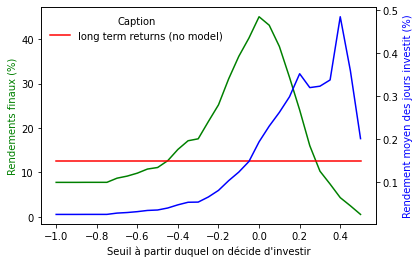

In [102]:
x=ensemble_seuils * 100
y1 = Total_gain_cumul_invest

y2= Total_returns_invest

y3 = Total_gain_long_terme

fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
ax1.plot(x, y1, 'g-')
ax1.plot(x, y3, 'r-', label = "long term returns (no model)")

ax2.plot(x, y2, 'b-')

ax1.set_xlabel("Seuil à partir duquel on décide d'investir")
ax1.set_ylabel("Rendements finaux (%)"  , color='g')
ax2.set_ylabel("Rendement moyen des jours investit (%)", color='b')
ax1.legend(loc="upper left", title="Caption", frameon=False)

plt.show()

Les rendements moyens journaliers atteignent un maximum local aux alentours des 0.2 puis diminuent jusqu'aux alentours des 0.35.

In [103]:
print("Le score d'accuracy max est de", round(max(Total_accuracy),3)*100,"%")
index = Total_accuracy.index(max(Total_accuracy))
print("Il est atteint pour le seuil :", ensemble_seuils[index])

Le score d'accuracy max est de 63.6 %
Il est atteint pour le seuil : 0.0


In [104]:
print("Les rendements maximums sont de :", round(max(Total_gain_cumul_invest),1), "%")
index = Total_gain_cumul_invest.index(max(Total_gain_cumul_invest))
print("Il sont atteints pour le seuil :", ensemble_seuils[index])

Les rendements maximums sont de : 45.0 %
Il sont atteints pour le seuil : 0.0


In [105]:
print("La precision maximale est de:", round(max(Total_precision),2), "%")
index = Total_precision.index(max(Total_precision))
print("Elle est atteinte pour le seuil de :", round(ensemble_seuils[index],3)*100)
print("Pour obtenir un tel score l'investissement ne se fait que sur ", round(Total_prop_invest[index],1), "% des jours")
print("Ainsi les rendements sont relativements faibles (",round(Total_gain_cumul_invest[index],1) ,"%) car malgré une precision elevée on investit très rarement")

La precision maximale est de: 0.78 %
Elle est atteinte pour le seuil de : 0.4
Pour obtenir un tel score l'investissement ne se fait que sur  2.3 % des jours
Ainsi les rendements sont relativements faibles ( 4.3 %) car malgré une precision elevée on investit très rarement


Encore une fois le seuil optimal semble être celui qu'on avait sélectionné. Cependant on décide de faire une deuxième étude en sélectionnant le seuil de 0.2 qui est encore un peu plus conservateur que celui du Random Forest.

### Résultats pour le seuil sélectionné <a class="anchor" id="432"></a>

In [106]:
index = np.where(ensemble_seuils==0.2/100)[0][0]
val_score_SVRSeuil = Total_accuracy[index]
print(val_score_SVRSeuil)

0.5291390728476821


L'accuracy score est de 52.9%, ce qui est beaucoup plus faible qu'avec les autres modèles. En voulant être trop prudent, on exclu de nombreux jours qui fournissaient des rendements positifs ce qui fait baisser l'accuracy.

In [107]:
best_SVR.fit(X_trainOpti, y_trainClassif)
y_pred_reg = best_SVR.predict(X_testOpti)
y_pred_regClassif = y_pred_reg>(0.2/100)

test_score_SVRSeuil = accuracy_score(y_testClassif, y_pred_regClassif)

print(test_score_SVRSeuil)

0.5496828752642706


In [108]:
Total_models["SVR>0.2"] = best_SVR
Total_best_params["SVR>0.2"] = best_SVR_params
Total_val_score["SVR>0.2"] = str(round(val_score_SVRSeuil*100,2))+ " %"
Total_test_score["SVR>0.2"] = str(round(test_score_SVRSeuil*100,2))+ " %"

# Récapitulatif des résultats et choix de l'investissement optimal <a class="anchor" id="5"></a>

Cette partie a pour but de choisir l'investissement optimal avant de calculer les résultats finaux sur le test set. Pour ce faire on va résumer l'ensemble des indicateurs dans un tableau récapitulatif, les prochaines fonctions vont nous permettent de remplir ce tableau.

## Fonctions permettant de remplir le tableau récapitulatif <a class="anchor" id="51"></a>

In [109]:
def InvestissementsModelesReg(model, seuil, type="Reg"):
    kf5 = KFold(n_splits=5, shuffle=False)
    
    returns_par_cross_set = []
    returns_daily_mean = []
    part_investing_days = []
    precision = []
    
    for train_index, valid_index in kf5.split(X_trainOpti):
        X_trainCV, X_validCV = X_trainOpti.iloc[train_index], X_trainOpti.iloc[valid_index]
        y_trainReg_CV, y_validClassif_CV = y_trainReg.iloc[train_index], y_trainClassif.iloc[valid_index]
        y_trainClassif_CV, y_validReg_CV = y_trainClassif.iloc[train_index],y_trainReg.iloc[valid_index]
        
        if type=="Classif":
            model.fit(X_trainCV, y_trainClassif_CV)
            y_pred_reg = model.predict_proba(X_validCV)[:,1]
            
        else :
            model.fit(X_trainCV, y_trainReg_CV)
            y_pred_reg = model.predict(X_validCV)
            
        y_pred = y_pred_reg>seuil
        
        cf = confusion_matrix(y_validClassif_CV, y_pred)
        precision.append(cf[1,1]/(cf[1,1]+cf[0,1]))
        
        gain_precedent = 100
        for i in range(len(y_pred)):
            if (y_pred[i]==1):
                gain_cumul = gain_precedent + (gain_precedent * list(y_validReg_CV)[i])
                gain_precedent = gain_cumul

        returns_par_cross_set.append(gain_cumul-100)
        returns_daily_mean.append(np.mean( y_validReg_CV[y_pred==1] ))
        part_investing_days.append(sum(y_pred==1)/len(y_pred))
        

    return(np.mean(returns_par_cross_set), np.mean(returns_daily_mean), np.mean(part_investing_days), np.mean(precision))    

In [110]:
Modeles = list(Total_models.keys())
Classif = Modeles[0:4]
Classif_avec_seuil = Modeles[4:]

In [111]:
Seuils = [0,0,0,0.6, 0.2/100] 
Type=["Reg","Reg","Reg","Classif", "Reg"]

In [112]:
Total_val_returns = []
Total_val_daily_returns = []
Total_val_investing_days = []
Total_val_precision = []

i = 0
for modele_name in Modeles:
    if modele_name in Classif :
        Model = Total_models[modele_name]
        v = InvestissementsModelesClassif(Model)
        
    if modele_name in Classif_avec_seuil : 
        Model = Total_models[modele_name]
        v = InvestissementsModelesReg(Model, Seuils[i], Type[i])
        i=i+1
        
    returns = str(round(v[0], 2))+" %"
    daily_returns = str(round(v[1]*100, 2))+" %"
    investing_days = str(round(v[2]*100, 2))+" %"
    precision = str(round(v[3]*100, 2))+" %"

    Total_val_returns.append(returns)
    Total_val_daily_returns.append(daily_returns)
    Total_val_investing_days.append(investing_days)
    Total_val_precision.append(precision)

### Fonction concernant l'investissement long-terme

In [113]:
kf5 = KFold(n_splits=5, shuffle=False)

val_score = []
precision = []
returns_par_cross_set = []
returns_daily_mean = []
    
for train_index, valid_index in kf5.split(X_trainOpti):
    X_trainCV, X_validCV = X_trainOpti.iloc[train_index], X_trainOpti.iloc[valid_index]
    y_trainReg_CV, y_validClassif_CV = y_trainReg.iloc[train_index], y_trainClassif.iloc[valid_index]
    y_trainClassif_CV, y_validReg_CV = y_trainClassif.iloc[train_index],y_trainReg.iloc[valid_index]
    
    y_pred = [1]*len(y_validClassif_CV)
    
    val_score.append(accuracy_score(y_validClassif_CV, y_pred))
    
    cf = confusion_matrix(y_validClassif_CV, y_pred)
    precision.append(cf[1,1]/(cf[1,1]+cf[0,1]))
        
    returns_daily_mean.append(np.mean(y_validReg_CV))

val_score_longCV = np.mean(val_score)    
precision_longCV =  str(round(np.mean(precision)*100,2))+ " %"
returns_longCV = str(round(Total_gain_long_terme[0],2))+" %"
returns_daily_mean_longCV = str(round(np.mean(returns_daily_mean)*100,2))+" %"

In [114]:
Total_val_returns.append(returns_longCV)
Total_val_daily_returns.append(returns_daily_mean_longCV)
Total_val_investing_days.append("100 %")
Total_val_precision.append(precision_longCV)

In [115]:
Total_models["No models - long term"] = ""
Total_best_params["No models - long term"] = ""
Total_val_score["No models - long term"] = str(round(val_score_longCV*100,2))+ " %"


## Tableau récapitulatif <a class="anchor" id="52"></a>

In [116]:
Summary_Validation = pd.DataFrame({'Best parameters': list(Total_best_params.values()), 'Val - Score': list(Total_val_score.values()),  'Val - Precision': Total_val_precision,'Val - Total returns': Total_val_returns, 'Val - Daily mean returns': Total_val_daily_returns,'Val - Part of investing days': Total_val_investing_days},
                      index = list(Total_models.keys()))
Summary_Validation

,Best parameters,Val - Score,Val - Precision,Val - Total returns,Val - Daily mean returns,Val - Part of investing days
CART,"{'criterion': 'gini', 'max_depth': 1}",61.99 %,64.57 %,39.68 %,0.19 %,56.75 %
RF,"{'criterion': 'entropy', 'max_depth': 4, 'n_es...",63.11 %,65.17 %,42.4 %,0.2 %,58.61 %
LASSO,"{'C': 10.0, 'penalty': 'l1'}",63.38 %,62.92 %,42.67 %,0.17 %,68.81 %
KNN,"{'metric': 'euclidean', 'n_neighbors': 66}",63.71 %,65.45 %,45.39 %,0.21 %,59.47 %
LinearReg>0,,62.98 %,65.29 %,42.13 %,0.2 %,57.55 %
SVR>0,"{'C': 0.1, 'epsilon': 0.0001, 'gamma': 1, 'ker...",63.64 %,64.58 %,45.04 %,0.19 %,62.45 %
ridge>0,{'alpha': 0.03},63.38 %,65.49 %,42.88 %,0.2 %,58.08 %
RF60,"{'criterion': 'entropy', 'max_depth': 4, 'n_es...",61.52 %,69.7 %,38.24 %,0.26 %,39.8 %
SVR>0.2,"{'C': 0.1, 'epsilon': 0.0001, 'gamma': 1, 'ker...",52.91 %,69.51 %,24.04 %,0.35 %,16.49 %
No models - long term,,54.44 %,54.44 %,12.57 %,0.03 %,100 %


Précisions sur les champs renseignées pour la ligne "No  models - long term" : 

* "Val - Score" et "Val - Precision" : part des jours durant lesquels les rendements du Dow Jones sont positifs

* "Val - Total returns" : Rendements long terme, sans toucher à son investissement sur la période. On investit au début et on revend en fin de période.

* "Val - Daily means returns" : Rendements moyen journaliers sur l'ensemble des jours travaillés

* "Val - Part of investing days" : 100% est ici renseigné, mais attention cela ne signifie pas que l'on investit tous les jours, mais bien que l'on garde notre investissement sur l'ensemble de la période. Cela n'est pas équivalent au fait d'investir tous les jours travaillés en achetant à l'ouverture et en revendant à la fermeture. (car la valeur de fermeture du jour n-1 n'est pas forcément égale à la valeur d'ouverture du jour n)

Observations et remarques sur le tableau :

* Le modèle KNN semble être le meilleur modèle, avec un accuracy score de 63.71% et des rendements de 45.39%. Par comparaison les rendements avec un investissement long-terme sont de 12.57%, soit une performance 3.6 fois supérieur.


    
* Le modèle CART qui est très basique (surtout vu le fait qu'il ne se base que sur une seule variable dans notre cas), obtient des résultats plutôt convaincants et rivalise avec les autres modèles plus complexes et qui utilisent plus de variables. On voit donc qu'il est très compliqué d'améliorer nos résultats dans cette analyse.


* Les modèles "RF60" et "SVR>0.2" dont on a parlé dans la partie précédente offrent des rendements inférieurs aux autres modèles, notamment à cause du fait que le nombre de jours sur lesquels un investissement est fait est plus faible. Cependant on observe que lorsqu'on investit les rendements journaliers sont en moyenne plus elevés. Ce sont donc des stratégies qui peuvent convenir à des investisseurs plus prudents. De plus ces rendements par jour plus elevés peuvent permettre d'amortir d'avantages les frais de courtage sur les investissements que l'on a pas encore évoqués mais qui sont en pratique bien présents.

Au final si l'on avait du choisir un modèle d'investissement pour prévoir les rendements des années 2019-2020 nous aurions choisis le modèle KNN qui semble donner les meilleurs performances. 

De plus, si l'on devait choisir un modèle plus prudent, on choisirait le modèle "SVR>0.2" qui permet de réaliser des investissements journaliers de rendements moyens de 0.35%, soit beaucoup plus que le modèle KNN qui est à 0.21%.

# Résultats sur le test set <a class="anchor" id="6"></a>

## Résultats finaux sur le test set (du 02/01/2019 aux 13/11/2020) <a class="anchor" id="61"></a>

On peut désormais enrichir notre tableau final avec le résultat sur le test set, qui nous permettra de vérifier la cohérence entre les résultats de validation et les résultats de test.

In [117]:
mise_initiale = 100

n=len(data_test["Close_DJ"])
returns_total = (data_test["Close_DJ"].iloc[n-1]-data_test["Open_DJ"].iloc[0])/data_test["Open_DJ"].iloc[0]
gain_strat_long_terme = mise_initiale * (1+ returns_total)

print(gain_strat_long_terme-100)

LongTermReturns = str(round((gain_strat_long_terme-100),2))+ " %"

27.84730452549246


28% de rendements moyen avec un investissement long terme sans utiliser de modèle entre le 2 janvier 2019 et le 13 novembre 2020

In [118]:
Total_test_returns = []
Total_test_daily_returns = []
Total_test_investing_days = []
Total_test_precision = []

j = 0
for modele_name in Modeles:
    Model = Total_models[modele_name]
    if modele_name in Classif :
        
        Model.fit(X_trainOpti, y_trainClassif)
        y_pred = Model.predict(X_testOpti)
        
    if modele_name in Classif_avec_seuil :
        
        if Type[j]=="Classif":
            Model.fit(X_trainOpti, y_trainClassif)
            y_pred_reg = Model.predict_proba(X_testOpti)[:,1]
            
        else :
            Model.fit(X_trainOpti, y_trainReg)
            y_pred_reg = Model.predict(X_testOpti)
            
        y_pred = y_pred_reg>Seuils[j]
        j= j+1

        
    cf = confusion_matrix(y_testClassif, y_pred)
    Total_test_precision.append(str(round(cf[1,1]/(cf[1,1]+cf[0,1])*100,2) )+" %")
        
    gain_precedent = 100
    for i in range(len(y_pred)):
        if (y_pred[i]==1):
            gain_cumul = gain_precedent + (gain_precedent * list(y_testReg)[i])
            gain_precedent = gain_cumul

    Total_test_returns.append(str(round(gain_cumul-100,2))+" %")
    Total_test_daily_returns.append(str(round(np.mean(y_testReg[y_pred==1])*100,2))+" %")
    Total_test_investing_days.append(str(round(sum(y_pred==1)*100/len(y_pred),2))+" %")

In [119]:
Total_test_score["No models - long term"]=str(round(np.mean(y_testClassif==1)*100,2))+" %"
Total_test_precision.append(Total_test_score["No models - long term"])
Total_test_returns.append(LongTermReturns)
Total_test_daily_returns.append(str(round(np.mean(y_testReg)*100,2))+" %")
Total_test_investing_days.append("100 %")

In [120]:
Summary_Test = pd.DataFrame({'Best parameters': list(Total_best_params.values()), 'Val - Score': list(Total_val_score.values()),  'Val - precision': Total_val_precision,'Val - Total returns': Total_val_returns, 'Val - Daily mean returns': Total_val_daily_returns,'Val - Part of investing days': Total_val_investing_days, 'Test - score' : list(Total_test_score.values()), 'Test - precision': Total_test_precision, "Test - returns" : Total_test_returns, "Test - daily mean returns" : Total_test_daily_returns, "Test - Part of investing days": Total_test_investing_days },
                      index = list(Total_models.keys()))


In [121]:
Summary_Test

,Best parameters,Val - Score,Val - precision,Val - Total returns,Val - Daily mean returns,Val - Part of investing days,Test - score,Test - precision,Test - returns,Test - daily mean returns,Test - Part of investing days
CART,"{'criterion': 'gini', 'max_depth': 1}",61.99 %,64.57 %,39.68 %,0.19 %,56.75 %,56.66 %,60.46 %,61.57 %,0.19 %,55.6 %
RF,"{'criterion': 'entropy', 'max_depth': 4, 'n_es...",63.11 %,65.17 %,42.4 %,0.2 %,58.61 %,58.99 %,62.22 %,85.39 %,0.24 %,57.08 %
LASSO,"{'C': 10.0, 'penalty': 'l1'}",63.38 %,62.92 %,42.67 %,0.17 %,68.81 %,58.77 %,60.38 %,84.98 %,0.2 %,66.17 %
KNN,"{'metric': 'euclidean', 'n_neighbors': 66}",63.71 %,65.45 %,45.39 %,0.21 %,59.47 %,59.2 %,61.92 %,78.31 %,0.21 %,59.41 %
LinearReg>0,,62.98 %,65.29 %,42.13 %,0.2 %,57.55 %,58.35 %,61.65 %,77.33 %,0.22 %,56.24 %
SVR>0,"{'C': 0.1, 'epsilon': 0.0001, 'gamma': 1, 'ker...",63.64 %,64.58 %,45.04 %,0.19 %,62.45 %,57.93 %,61.62 %,81.45 %,0.22 %,60.04 %
ridge>0,{'alpha': 0.03},63.38 %,65.49 %,42.88 %,0.2 %,58.08 %,57.93 %,60.59 %,67.54 %,0.2 %,56.87 %
RF60,"{'criterion': 'entropy', 'max_depth': 4, 'n_es...",61.52 %,69.7 %,38.24 %,0.26 %,39.8 %,57.93 %,65.8 %,62.91 %,0.26 %,40.8 %
SVR>0.2,"{'C': 0.1, 'epsilon': 0.0001, 'gamma': 1, 'ker...",52.91 %,69.51 %,24.04 %,0.35 %,16.49 %,54.97 %,69.7 %,46.29 %,0.39 %,20.93 %
No models - long term,,54.44 %,54.44 %,12.57 %,0.03 %,100 %,54.97 %,54.97 %,27.85 %,0.02 %,100 %


Observations et remarques sur le tableau :

* Le modèle KNN que nous avons sélectionné est également le modèle avec le meilleure score d'accuracy de test vu qu'il est en effet de 59.2%. Cependant niveau rendements, ce n'est pas le meilleure, le modèle de Random Forest le devance avec des rendements de 85,39% sur les 2 ans contre 78,31% pour KNN. Ces rendements restent tout de même très satisfaisants vu qu'ils sont 3 fois supérieurs aux rendements sur le long terme.


* Le modèle CART, malgré sa simplicité, obtient des rendements presque 2 fois supérieurs aux rendements long terme


* Le modèle "SVR>0.2" plus prudent que nous avons choisis, obtient des rendements journaliers moyen de pratiquement 0.4%, avec un rendement total sur la période de 46.29% en ayant investi durant 20.93% des jours.

## Résultats en période de crise (du 12/02/2020 au 23/03/2020) <a class="anchor" id="62"></a>

L'idée de cette partie est de tester les résultats de nos modèles en période de crise. Nous avons sélectionné la période allant du 12 février 2020 au 23 mars 2020, période pendant laquelle l'indice du Dow Jones a chuté de 36.78%.

In [122]:
data_test_crisis = data_test.iloc[280:308].reset_index(drop=True)
y_testReg_crisis = data_test_crisis["Returns_DJ"]
y_testClassif_crisis = data_test_crisis["Returns_DJ_positive"]
X_testOpti_crisis = data_test_crisis[VarExpli]


mise_initiale = 100

n=len(data_test_crisis["Close_DJ"])
returns_total = (data_test_crisis["Close_DJ"].iloc[n-1]-data_test_crisis["Open_DJ"].iloc[0])/data_test_crisis["Open_DJ"].iloc[0]
gain_strat_long_terme = mise_initiale * (1+ returns_total)

print(gain_strat_long_terme-100)

LongTermReturns = str(round((gain_strat_long_terme-100),2))+ " %"

-36.77665948124156


In [123]:
Total_test_returns = []
Total_test_daily_returns = []
Total_test_investing_days = []
Total_test_precision = []
Total_test_accuracy = []

j = 0
for modele_name in Modeles:
    Model = Total_models[modele_name]
    if modele_name in Classif :
        
        Model.fit(X_trainOpti, y_trainClassif)
        y_pred = Model.predict(X_testOpti_crisis)
        
    if modele_name in Classif_avec_seuil :
        
        if Type[j]=="Classif":
            Model.fit(X_trainOpti, y_trainClassif)
            y_pred_reg = Model.predict_proba(X_testOpti_crisis)[:,1]
            
        else :
            Model.fit(X_trainOpti, y_trainReg)
            y_pred_reg = Model.predict(X_testOpti_crisis)
            
        y_pred = y_pred_reg>Seuils[j]
        j= j+1

    acc = accuracy_score(y_testClassif_crisis, y_pred)*100  
    Total_test_accuracy.append(str(round(acc,2))+" %")   
    
    cf = confusion_matrix(y_testClassif_crisis, y_pred)
    Total_test_precision.append(str(round(cf[1,1]/(cf[1,1]+cf[0,1])*100,2) )+" %")
        
    gain_precedent = 100
    for i in range(len(y_pred)):
        if (y_pred[i]==1):
            gain_cumul = gain_precedent + (gain_precedent * list(y_testReg_crisis)[i])
            gain_precedent = gain_cumul

    Total_test_returns.append(str(round(gain_cumul-100,2))+" %")
    Total_test_daily_returns.append(str(round(np.mean(y_testReg_crisis[y_pred==1])*100,2))+" %")
    Total_test_investing_days.append(str(round(sum(y_pred==1)*100/len(y_pred),2))+" %")


In [124]:
Total_test_accuracy.append(str(round(np.mean(y_testClassif_crisis==1)*100,2))+" %")
Total_test_precision.append(str(round(np.mean(y_testClassif_crisis==1)*100,2))+" %")
Total_test_returns.append(LongTermReturns)
Total_test_daily_returns.append(str(round(np.mean(y_testReg_crisis)*100,2))+" %")
Total_test_investing_days.append("100 %")

In [125]:
Summary_test_crisis = pd.DataFrame({'Best parameters': list(Total_best_params.values()), 'Val - Score': list(Total_val_score.values()),  'Val - precision': Total_val_precision,'Val - Total returns': Total_val_returns, 'Val - Daily mean returns': Total_val_daily_returns,'Val - Part of investing days': Total_val_investing_days, 'Test - score' : Total_test_accuracy, 'Test - precision': Total_test_precision, "Test - returns" : Total_test_returns, "Test - daily mean returns" : Total_test_daily_returns, "Test - Part of investing days": Total_test_investing_days },
                      index = list(Total_models.keys()))


In [126]:
Summary_test_crisis

,Best parameters,Val - Score,Val - precision,Val - Total returns,Val - Daily mean returns,Val - Part of investing days,Test - score,Test - precision,Test - returns,Test - daily mean returns,Test - Part of investing days
CART,"{'criterion': 'gini', 'max_depth': 1}",61.99 %,64.57 %,39.68 %,0.19 %,56.75 %,75.0 %,66.67 %,6.42 %,0.75 %,32.14 %
RF,"{'criterion': 'entropy', 'max_depth': 4, 'n_es...",63.11 %,65.17 %,42.4 %,0.2 %,58.61 %,71.43 %,60.0 %,3.47 %,0.39 %,35.71 %
LASSO,"{'C': 10.0, 'penalty': 'l1'}",63.38 %,62.92 %,42.67 %,0.17 %,68.81 %,67.86 %,54.55 %,8.56 %,0.78 %,39.29 %
KNN,"{'metric': 'euclidean', 'n_neighbors': 66}",63.71 %,65.45 %,45.39 %,0.21 %,59.47 %,67.86 %,55.56 %,4.47 %,0.52 %,32.14 %
LinearReg>0,,62.98 %,65.29 %,42.13 %,0.2 %,57.55 %,71.43 %,62.5 %,4.97 %,0.64 %,28.57 %
SVR>0,"{'C': 0.1, 'epsilon': 0.0001, 'gamma': 1, 'ker...",63.64 %,64.58 %,45.04 %,0.19 %,62.45 %,67.86 %,55.56 %,4.19 %,0.49 %,32.14 %
ridge>0,{'alpha': 0.03},63.38 %,65.49 %,42.88 %,0.2 %,58.08 %,67.86 %,55.56 %,4.19 %,0.49 %,32.14 %
RF60,"{'criterion': 'entropy', 'max_depth': 4, 'n_es...",61.52 %,69.7 %,38.24 %,0.26 %,39.8 %,71.43 %,66.67 %,0.01 %,0.03 %,21.43 %
SVR>0.2,"{'C': 0.1, 'epsilon': 0.0001, 'gamma': 1, 'ker...",52.91 %,69.51 %,24.04 %,0.35 %,16.49 %,71.43 %,75.0 %,8.3 %,2.05 %,14.29 %
No models - long term,,54.44 %,54.44 %,12.57 %,0.03 %,100 %,35.71 %,35.71 %,-36.78 %,-0.65 %,100 %


Observations et remarques sur le tableau :

* L'ensemble de nos modèles retournent des rendements positifs sur la période ce qui est une plutôt bonne performance étant donné la situation.


* Les modèles investissent ici en moyenne 30% des jours contre 60%  des jours dans le tableau précédent, les modèles ont donc bien évalué cette situation de crise.


* Le modèle plus prudent "RF>0.2" qu'on avait selectionné a investit seulement 4 jours sur les 28 constituant la période, avec des rendements moyen sur ces 4 jours de l'ordre des 2% avec un rendement total de 8%

# Prochaines étapes et limites de l'étude <a class="anchor" id="7"></a>

## Learning Curve - Besoin de données supplémentaires ? <a class="anchor" id="71"></a>

[ 120  392  664  936 1208]


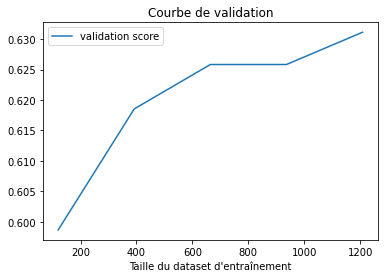

In [127]:
from sklearn.model_selection import learning_curve

N, train_score, val_score = learning_curve(best_RF, X_trainOpti, y_trainClassif, train_sizes = np.linspace(0.1, 1, 5), cv=5)

print(N)
plt.plot(N, val_score.mean(axis=1), label="validation score")
plt.title("Courbe de validation")
plt.xlabel("Taille du dataset d'entraînement")
plt.legend()

L'idée de cette courbe est de représenter l'évolution du score de validation en fonction de la taille du dataset sur lequel on s'entraîne.

Ici, on observe que la courbe ne semble pas clairement stagner, il pourra donc éventuellement être utile de disposer de d'avantages de données sur la période avant 2013. D'un point de vue opérationnel cela impliquera de devoir acheter ces données étant donné qu'elles ne sont pas trouvables gratuitement en ligne.

## Limites et améliorations possibles <a class="anchor" id="72"></a>

Limites :
    
   * **Stratégie d'investissement difficilement réalisable en pratique**

1- Impossible d'acheter  exactement au prix d'ouverture et de vendre exactement au prix de fermeture
    
    
2- Les fonds indexés sur les indices boursiers ne suivent pas exactement les rendements du Dow Jones, il faudrait donc quantifier cet écart et ses conséquences.
    
    
3- Cette étude ne prend en compte à aucun moment les frais de courtage sur les actions qui peuvent s'appliquer par exemple lorsqu'on un passe un ordre de vente et un ordre d'achat. Dans le cas ou ces frais seraient trop élevées cela pourrait rendre totalement obsolète la stratégie.
    
    
  * **Les données concernant les rendements à 15h ont été extraites d'une base de données gratuite. Cette donnée étant habituellement payante, un travail de fiabilisation supplémentaire de ces données serait préférable. De plus il serait intéressant d'enrichir la base avec les données avant 2013 pour éventuellement améliorer la phase d'apprentissage de nos modèles.**
  
  
  * **Les rendements passés du Dow Jones n'ont pas été pris en compte dans l'étude. Un travail plus profond sur des problématiques de séries temporelles pourrait être intéréssant pour améliorer nos scores et nos rendements (Modèle ARIMA, LSTM etc...)**
  
  
  * **Une étude plus précise des corrélations pourrait être intégré, avec l'introduction de copules par exemple**

# Conclusion <a class="anchor" id="8"></a>

Pour conclure, il apparaît très clairement dans cette étude que les rendements des indices internationaux avant ouverture de Wall Street peuvent aider à prédire la tendance du jour du Dow Jones avec une précision aux alentours de 59% sur la période de test 2019-2020. Un score d'autant plus satisfaisant qu'uniquement les données du jour J sont utilisées pour prédire les rendements du jour J.

De plus, malgré la complexité de l'interprétation de certains algorithmes, l'idée derrière est assez claire, plus les rendements des indices internationaux sont positifs et plus ceux du Dow Jones le seront aussi selon les modélisations.

Il apparaît également que la complexité des modèles n'apporte pas une plus-value flagrante, à l'image du modèle CART dont le score de précision atteint pratiquement les 57% malgré sa simplicité.

Par la suite, en considérant une stratégie d'investissement journalière sur les jours dont la tendance prédite est positive, on peut obtenir des rendements théoriques environ 3 fois supérieures aux rendements long-terme sur la même période. Cependant, en pratique, cette stratégie est loin d'être facilement réalisable.

Enfin, que la stratégie d'investissement soit fiable ou non, cette analyse nous apporte quand même un certain point de vue sur les liens qu'il peut y avoir entre les différentes bourses. Si le marché américain est certes très influent, entre la fermeture de Wall Street du jour n-1 et l'ouverture du jour n, il peut se passer de nombreuses choses dans le monde et n'importe quelle évènement  ayant lieu dans cet intervalle peut d'abord se faire ressentir sur les bourses non américaines puis dans un deuxième temps sur les bourses américaines.